In [1]:
import datetime
import sys
sys.path.append("..")
import random
from numpy.random import default_rng
from annoy import AnnoyIndex
import torch.autograd as autograd
from typing import List
import anndata
from functools import partial
from copy import deepcopy

from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from sklearn.metrics import (adjusted_rand_score, calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
import math
import utils
from sklearn import metrics
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
import colorcet as cc

import math
from scipy import sparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from random import sample
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.utils.spectral_norm as spectral_norm
import torch.nn.utils.weight_norm as weight_norm
import torch.optim.lr_scheduler as lr_scheduler
import scanpy as sc
import time
import os
from scipy import sparse
# from adabelief_pytorch import AdaBelief
import torch.quantization

import gzip

from torch.utils.data import WeightedRandomSampler

# from utils.explanation_utils import explanation_hook, get_explanation
from sklearn.preprocessing import MinMaxScaler
import gc

torch.cuda.set_device(3)

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

from anndata import AnnData
    
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# import warnings
# warnings.filterwarnings("ignore")

path= "../"

# check available files
# !ls ../real_data

torch.autograd.set_detect_anomaly(True)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

########## NEURAL NETWORK UTILITY ##########
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

CPUTensor =  torch.FloatTensor

In [2]:
sc.settings.verbosity = 1

sc.settings.set_figure_params(
    dpi=200, frameon=False, figsize=(3, 3), facecolor='white')

In [3]:
## /acrc/jinmiao/CJM_lab/hoatran/demo_normalization/dataset/dataset5_human_pbmc/raw_data_python/myTotalData.h5ad

In [4]:
# AissaBenevolenskaya2021
# PapalexiSatija2021_eccite_arrayed_RNA
# ZhaoSims2021
# GSE115943
# GSE106340
adata = sc.read_h5ad("data/lupus/kang_raw.h5ad")
adata = adata[adata.obs.multiplets == "singlet"].copy()

# remove the null value from the dataset
# adata = adata[np.array(~adata.obs.condition.isna())]
# adata = adata[adata.obs["GSM"].isin(["GSM2836284", "GSM2836288"])].copy()


# adata_test = sc.read_h5ad("data/SchiebingerLander2019_GSE115943.h5ad")
# adata_test = adata_test[np.array(~adata_test.obs.condition.isna())]
# adata_test = adata_test[adata_test.obs["GSM"].isin(["GSM3195770", "GSM3195772"])]

# adata = adata.concatenate(adata_test)

# adata = adata[adata.obs["sample"].isin(["PW032"])]

# adata = adata[np.array(adata.obs["GSM"].isin(["GSM2836281", "GSM2836283"]))]

# remove nan values from the dataset

# storing the layers count
# adata.layers["counts"] = adata.X
# KLF1
# targeted_label = "KLF1"

In [5]:
targeted_label = "stim"

In [6]:
# adata = adata[adata.obs.condition.isin(["control", targeted_label])].copy()

In [7]:
pd.__version__

'2.1.1'

In [8]:
adata.obs.condition

barcode
AAACATACATTTCC-1    ctrl
AAACATACCAGAAA-1    ctrl
AAACATACCATGCA-1    ctrl
AAACATACCTCGCT-1    ctrl
AAACATACCTGGTA-1    ctrl
                    ... 
TTTGCATGCCTGAA-1    stim
TTTGCATGCCTGTC-1    stim
TTTGCATGCTAAGC-1    stim
TTTGCATGGGACGA-1    stim
TTTGCATGTCTTAC-1    stim
Name: condition, Length: 24483, dtype: category
Categories (2, object): ['ctrl', 'stim']

In [9]:
# find the lowest classes and remove
# adata.obs.groupby(["condition"]).count()

In [10]:
np.amax(adata.X)

3828.0

In [11]:
adata.obs

,sample_id,condition,cluster,cell_type,multiplets,n_genes
barcode,,,,,,
AAACATACATTTCC-1,1016,ctrl,9,CD14+ Monocytes,singlet,878
AAACATACCAGAAA-1,1256,ctrl,9,CD14+ Monocytes,singlet,713
AAACATACCATGCA-1,1488,ctrl,3,CD4 T cells,singlet,337
AAACATACCTCGCT-1,1256,ctrl,9,CD14+ Monocytes,singlet,850
AAACATACCTGGTA-1,1039,ctrl,4,Dendritic cells,singlet,1111
...,...,...,...,...,...,...
TTTGCATGCCTGAA-1,1244,stim,6,CD4 T cells,singlet,468
TTTGCATGCCTGTC-1,1256,stim,4,B cells,singlet,819
TTTGCATGCTAAGC-1,107,stim,6,CD4 T cells,singlet,523


In [12]:
adata.obs["condition"]

barcode
AAACATACATTTCC-1    ctrl
AAACATACCAGAAA-1    ctrl
AAACATACCATGCA-1    ctrl
AAACATACCTCGCT-1    ctrl
AAACATACCTGGTA-1    ctrl
                    ... 
TTTGCATGCCTGAA-1    stim
TTTGCATGCCTGTC-1    stim
TTTGCATGCTAAGC-1    stim
TTTGCATGGGACGA-1    stim
TTTGCATGTCTTAC-1    stim
Name: condition, Length: 24483, dtype: category
Categories (2, object): ['ctrl', 'stim']

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# sc.pp.filter_cells(adata_test, min_genes=200)
# sc.pp.filter_genes(adata_test, min_cells=3)

In [14]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# adata_test.var['mt'] = adata_test.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata_test, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

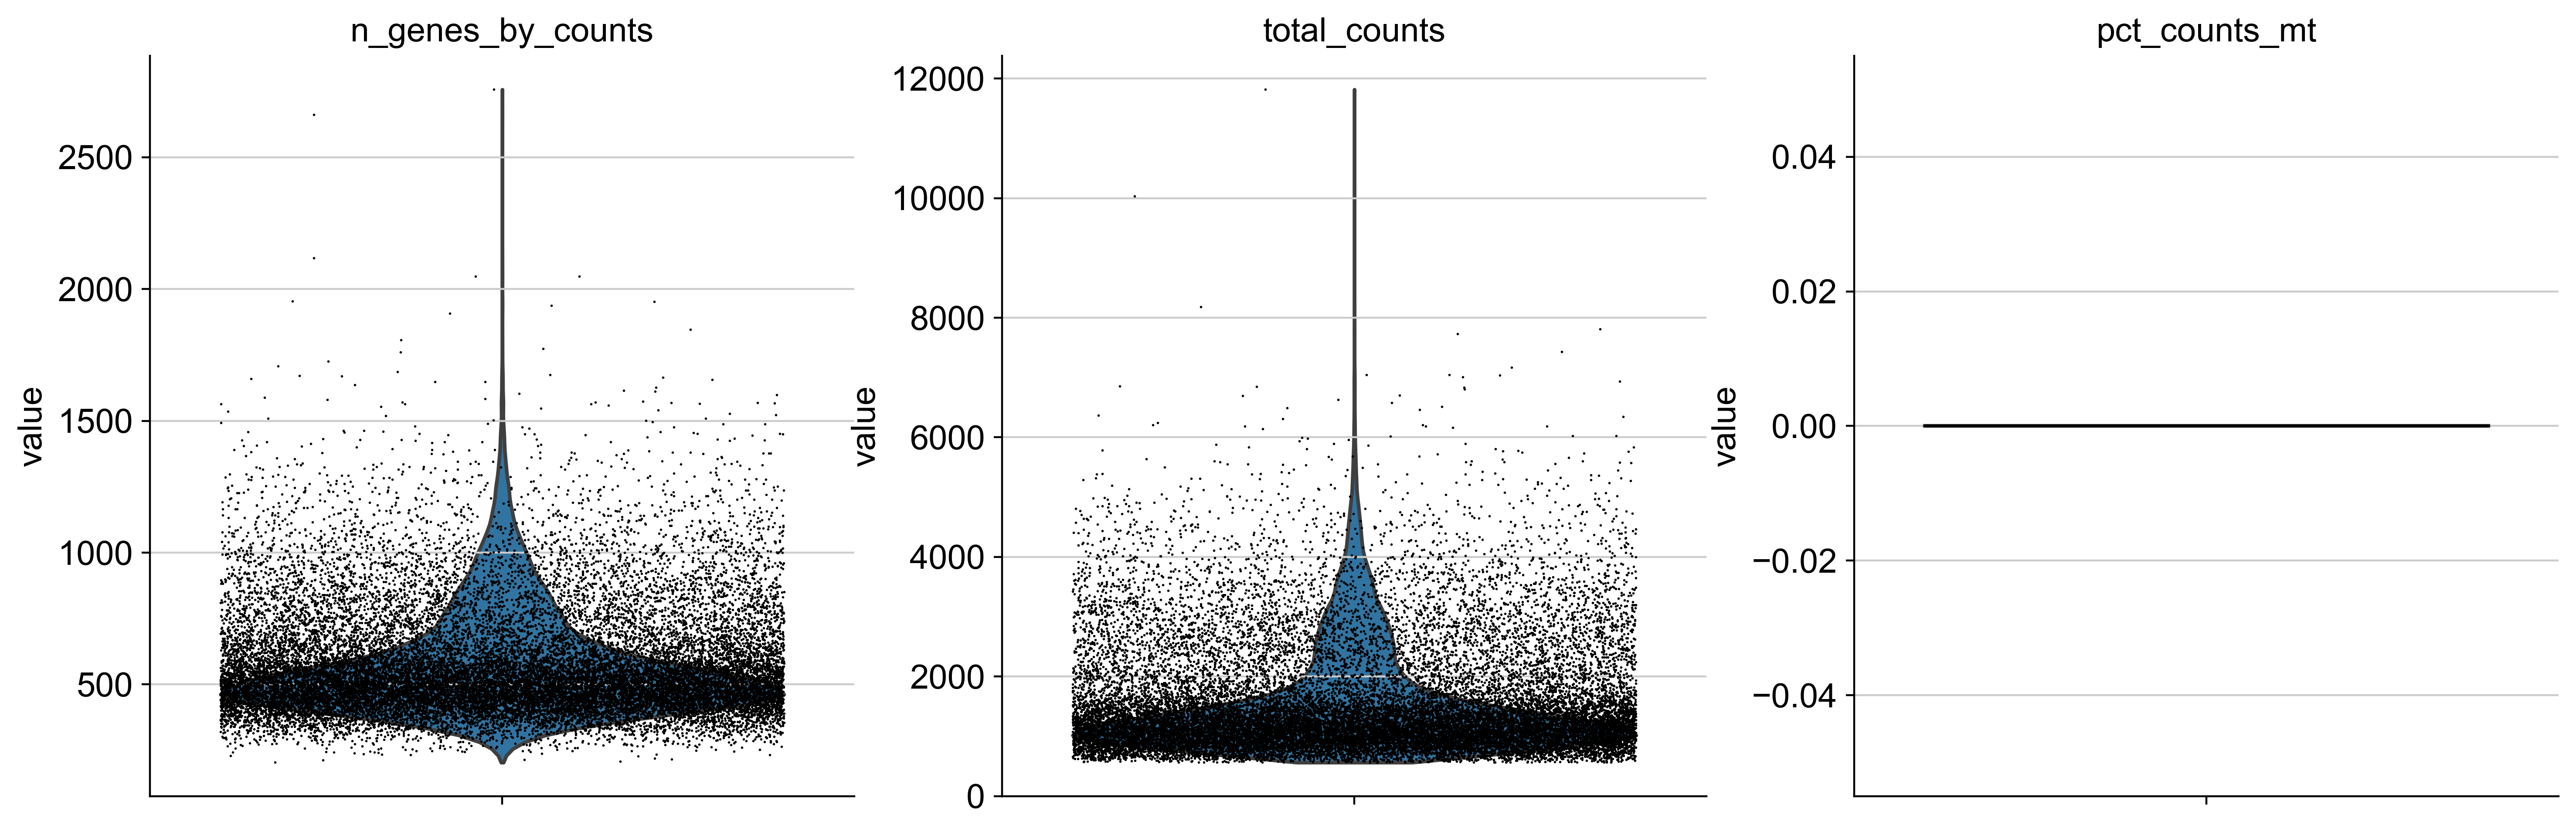

In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

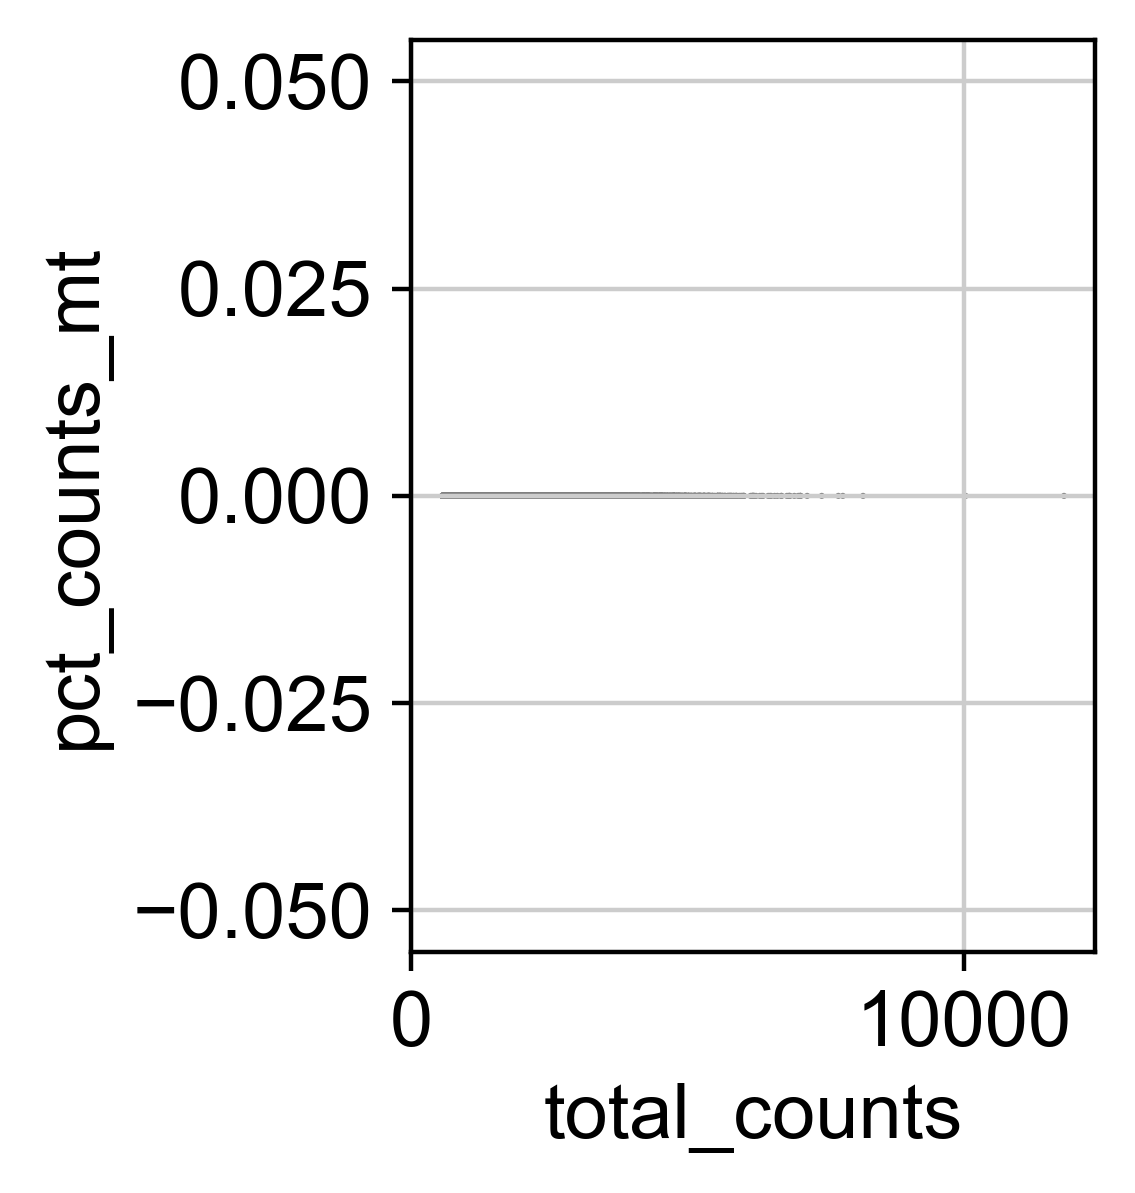

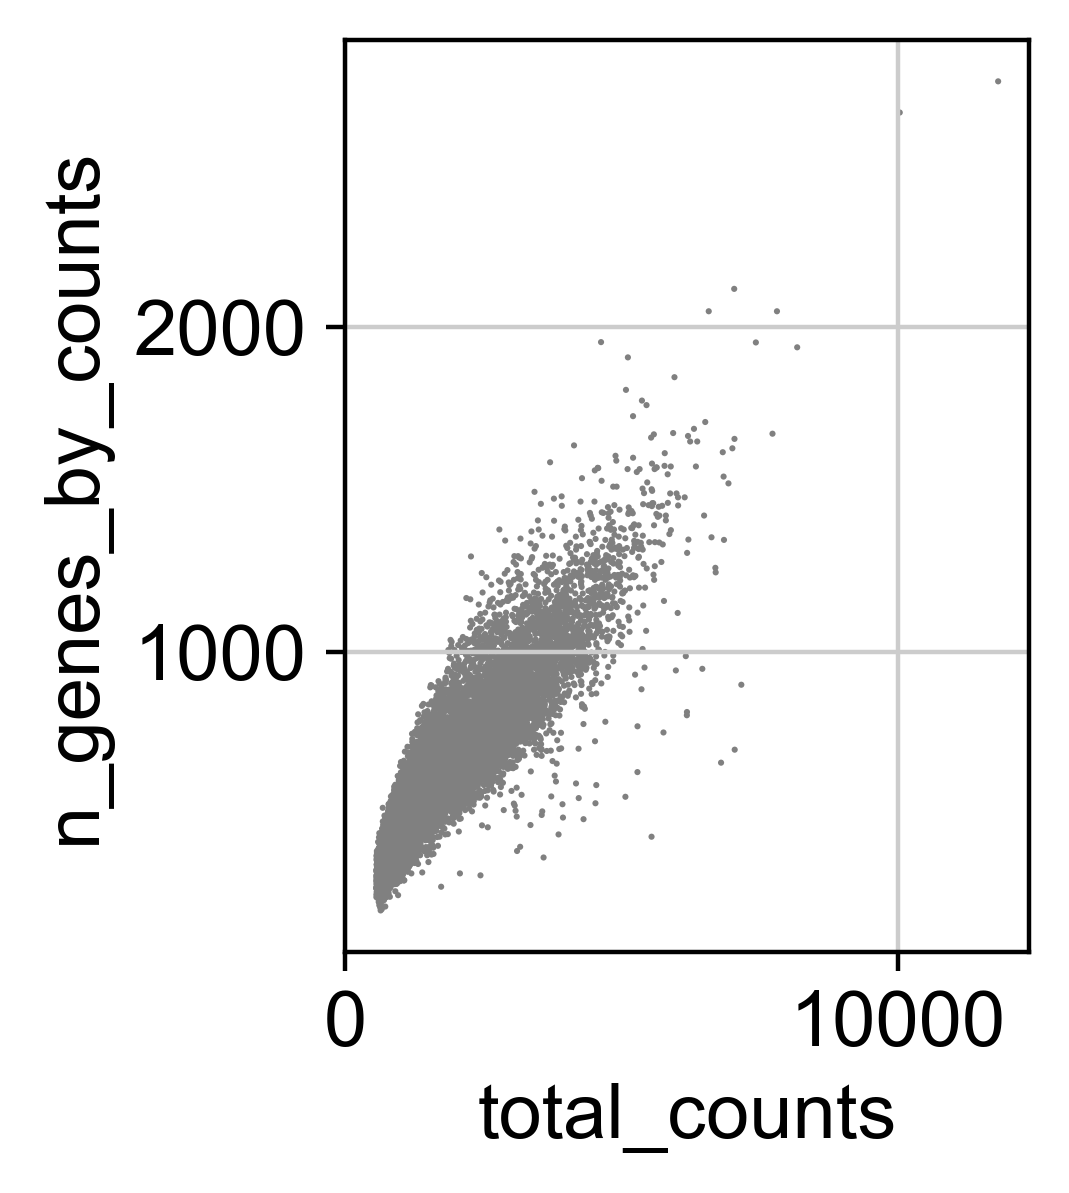

In [16]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [17]:
adata = adata[adata.obs.n_genes_by_counts < 1500, :]
adata = adata[adata.obs.pct_counts_mt < 8, :]

# adata_test = adata_test[adata_test.obs.n_genes_by_counts < 5000, :]
# adata_test = adata_test[adata_test.obs.pct_counts_mt < 8, :]

In [18]:
# adata_test = adata[adata.obs.nperts > 1].copy()
# adata = adata[adata.obs.nperts <= 1].copy()

In [19]:
# adata.obs["sample"]

In [20]:
# setup_seed(8)
# adata = adata[np.random.choice(165748, 10000, replace=False)]

In [21]:
adata.obs.condition

barcode
AAACATACATTTCC-1    ctrl
AAACATACCAGAAA-1    ctrl
AAACATACCATGCA-1    ctrl
AAACATACCTCGCT-1    ctrl
AAACATACCTGGTA-1    ctrl
                    ... 
TTTGCATGCCTGAA-1    stim
TTTGCATGCCTGTC-1    stim
TTTGCATGCTAAGC-1    stim
TTTGCATGGGACGA-1    stim
TTTGCATGTCTTAC-1    stim
Name: condition, Length: 24428, dtype: category
Categories (2, object): ['ctrl', 'stim']

In [22]:
# adata.obs["celltype"]

In [23]:
# adata.obs["condition_type"]

In [24]:
# adata.obs["disease"]

In [25]:
# # subset to only the high quality cells
# adata = adata[adata.obs["cell_quality"] == "high"].copy()
# adata

In [26]:
# metadata = adata.obs

# project_list = list(metadata.groupby("projectID").count().sort_values(by = "orig.ident", ascending=False).index[:1].values)

# # project_list

# adata_subset = adata[adata.obs["projectID"].isin(project_list)].copy()
# adata = adata_subset.copy()

In [27]:
# # code to clean out the data with NaN on age
# # got around 1,836,374 cells that including age
# # feasible to used as the dataset

# # (adata.obs.Age > 0).sum()

# # create new h5ad data and mainly focusing on the Age.

# adata_subset = adata[(adata.obs.Age > 0).values].copy()
# removing the NA annotation in the data as we want a proper estimating for different condition
# adata_subset = adata[adata.obs.Severity != "NA"]
# adata_subset.write_h5ad("data/COVID_age.h5ad")

In [28]:
# adata_subset.obs["Severity"]

In [29]:
sc.__version__

'1.9.3'

In [30]:
import scipy.special
from sklearn.metrics.cluster import adjusted_rand_score


def ari(adata, group1, group2, implementation="sklearn"):
    """Adjusted Rand Index
    The function is symmetric, so group1 and group2 can be switched
    For single cell integration evaluation the comparison is between predicted cluster
    assignments and the ground truth (e.g. cell type)
    :param adata: anndata object
    :param group1: string of column in adata.obs containing labels
    :param group2: string of column in adata.obs containing labels
    :param implementation: if set to 'sklearn', uses sklearn's implementation,
        otherwise native implementation is taken
    """

    group1 = adata.obs[group1].to_numpy()
    group2 = adata.obs[group2].to_numpy()

    if len(group1) != len(group2):
        raise ValueError(
            f"different lengths in group1 ({len(group1)}) and group2 ({len(group2)})"
        )

    return adjusted_rand_score(group1, group2)

def compute_ari(adata):

    resolutions = None

    if resolutions is None:
        n = 20
        resolutions = [2 * x / n for x in range(1, n + 1)]

    score_max = 0
    res_max = resolutions[0]
    clustering = None
    score_all = []
    use_rep = "X_pca"
    cluster_key = "louvain"
    label_key = "CellType"

    try:
        adata.uns["neighbors"]
    except KeyError:
        if verbose:
            print("computing neighbours for opt_cluster")
        sc.pp.neighbors(adata, use_rep=use_rep)

    for res in resolutions:
        sc.tl.louvain(adata, resolution=res, key_added=cluster_key)
        score = ari(adata, label_key, cluster_key)
        score_all.append(score)
        if score_max < score:
            score_max = score
            res_max = res
            clustering = adata.obs[cluster_key]

    return score_max

In [31]:
# flavor: seurat_v3, cell_ranger & log = false
def sub_data_preprocess(adata: sc.AnnData, n_top_genes: int = 5000, batch_key: str = None, flavor: str = 'seurat_v3', min_genes: int = 200, min_cells: int = 3) -> sc.AnnData:
#     sc.pp.filter_cells(adata, min_genes=min_genes)
#     sc.pp.filter_genes(adata, min_cells=min_cells)
    if flavor == 'seurat_v3':
# #         count data is expected when flavor=='seurat_v3'
#         sc.pp.highly_variable_genes(
#             adata, flavor=flavor, batch_key = batch_key)
        sc.pp.highly_variable_genes(
            adata, flavor=flavor, n_top_genes=n_top_genes)

#     if flavor != 'seurat_v3':.
#         # log-format data is expected when flavor!='seurat_v3'
#         sc.pp.highly_variable_genes(
#             adata, n_top_genes=n_top_genes, flavor=flavor)
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    return adata


def data_preprocess(adata: sc.AnnData, key: str = 'batch', n_top_genes: int = 2000, flavor: str = 'seurat_v3', min_genes: int = 200, min_cells: int = 3, n_batch: int = 2) -> sc.AnnData:
    print('Establishing Adata for Next Step...')
    hv_adata = sub_data_preprocess(adata, n_top_genes=n_top_genes, batch_key = key, flavor=flavor, min_genes=min_genes, min_cells=min_cells)
    if len(adata.var.index) > n_top_genes:
        hv_adata = hv_adata[:, hv_adata.var['highly_variable']]
#     hv_adata.X = np.expm1(hv_adata.X)
    print('PreProcess Done.')
    return hv_adata

In [32]:
# batch_str = "batch_num"

adata = data_preprocess(adata)
adata  # Output the basic information of the preprocessed data.

Establishing Adata for Next Step...


/home/rom/miniforge3/envs/pertpy/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:149: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': 'seurat_v3'}


PreProcess Done.


View of AnnData object with n_obs × n_vars = 24428 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [33]:
# adata.obs["sample"] = adata.obs["batch"]

In [34]:
# # get the genes from the training data and then normalising it
# # sc.pp.normalize_per_cell(adata_test, counts_per_cell_after=1e4)
# # sc.pp.log1p(adata_test)
# # adata_test = adata_test[:, adata.var.index].copy()

# # 772 & 288 are the control

# adata_test = adata[adata.obs["GSM"].isin(["GSM3195770", "GSM3195772"])]
# adata =  adata[adata.obs["GSM"].isin(["GSM2836284", "GSM2836288", "GSM3195772"])]

In [35]:
# adata.obs.GSM

In [36]:
# using the difference one to be the testing set
adata_test = adata[np.array(adata.obs["sample_id"].isin([1016]))].copy()
adata_test

AnnData object with n_obs × n_vars = 3334 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [37]:
# remove the data from the training data
adata = adata[~np.array(adata.obs["sample_id"].isin([1016]))].copy()
adata

AnnData object with n_obs × n_vars = 21094 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [38]:
setup_seed(8)
# held out a portion of control cells for making prediction in the evaluation phase
control_test = adata_test[adata_test.obs.condition == "ctrl"]
# control_test = control_test[np.random.choice(control_test.shape[0], 1000, replace=False)]
control_test

View of AnnData object with n_obs × n_vars = 1758 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

## Split the data into training and testing

In [39]:
# setup_seed(8)
# # held out a portion of control cells for making prediction in the evaluation phase
# control_test = adata[adata.obs.condition == "control"]
# control_test = control_test[np.random.choice(control_test.shape[0], 1000, replace=False)]
# control_test = sc.read_h5ad("normal_control_test.h5ad")

In [40]:
control_test

View of AnnData object with n_obs × n_vars = 1758 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [41]:
# # remove the testing sample from the training data
# train_index = []

# for each in adata.obs.index:
#     if each in control_test.obs.index:
#         train_index.append(False)
#     else:
#         train_index.append(True)

# # i.i.d
# adata = adata[np.array(train_index)].copy()

In [42]:
adata.obs.condition

barcode
AAACATACCAGAAA-1    ctrl
AAACATACCATGCA-1    ctrl
AAACATACCTCGCT-1    ctrl
AAACATACCTGGTA-1    ctrl
AAACATACGATGAA-1    ctrl
                    ... 
TTTGCATGCATGAC-1    stim
TTTGCATGCCTGAA-1    stim
TTTGCATGCCTGTC-1    stim
TTTGCATGCTAAGC-1    stim
TTTGCATGGGACGA-1    stim
Name: condition, Length: 21094, dtype: category
Categories (2, object): ['ctrl', 'stim']

In [43]:
adata.obs["batch"] = adata.obs["condition"]

le = preprocessing.LabelEncoder()
new_batch = le.fit_transform(adata.obs["batch"])
adata.obs["batch"] = new_batch

new_batch = [str(each) for each in new_batch]
adata.obs["batch_num"] = new_batch

In [44]:
# # get the genes from the training data and then normalising it
# adata_test = adata_test[:, adata.var.index].copy()
# sc.pp.normalize_per_cell(adata_test, counts_per_cell_after=1e4)
# sc.pp.log1p(adata_test)

In [45]:
adata.layers["log_norm"] = adata.X.copy()

In [46]:
setup_seed(8)

In [47]:
import scanpy as sc
import pandas as pd
import seaborn as sns

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 1
sc.settings.set_figure_params(
    dpi=300, frameon=False, figsize=(3, 3), facecolor='white')

# check the umap after normalisation

# compute pca and neighbor for calculating the ARI score
# sc.pp.pca(adata)
# sc.pp.neighbors(adata, n_neighbors=30)
# sc.tl.umap(adata)

# sc.pl.umap(adata, color=['batch', 'CellType'],
#            palette=sc.pl.palettes.vega_20_scanpy)

# revert based to unscale data
# adata.X = adata.layers["log_norm"]

In [48]:
# adata

In [49]:
# adata.obs["batch_num"]

In [50]:
import colorcet as cc

In [51]:
custom_palette = cc.glasbey_category10

# sc.pl.umap(adata, color=['batch_num'], legend_loc = "none",
#            palette=custom_palette)

In [52]:
adata

AnnData object with n_obs × n_vars = 21094 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'batch', 'batch_num'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    layers: 'log_norm'

In [53]:
# adata.obs.guide_id

In [54]:
from sklearn.preprocessing import OneHotEncoder

# le = preprocessing.LabelEncoder()
enc_batch = OneHotEncoder(handle_unknown='ignore')
# enc_group = OneHotEncoder(handle_unknown='ignore')

label_str = "batch"
# group_str = "condition"

enc_batch.fit(adata.obs[label_str].to_numpy().reshape(-1, 1))
# enc_group.fit(adata.obs[group_str].to_numpy().reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore')

In [55]:
########## CLASS SINGLE CELL DATASET ##########
class ScDataset(Dataset):
    def __init__(self, adata):
        self.variable = None
        self.labels = adata.obs[label_str].to_numpy()
        self.org_batch = adata.obs[label_str].to_numpy()
#         self.groups = adata.obs[group_str].to_numpy()
        self.one_hot_labels = enc_batch.transform(adata.obs[label_str].to_numpy().reshape(-1, 1)).toarray()
#         self.one_hot_groups = enc_group.transform(adata.obs[group_str].to_numpy().reshape(-1, 1)).toarray()
        try:
            self.X = adata.X.toarray()
#             self.hvg_X = adata[:, adata.var['highly_variable']].X.copy().toarray()
        except:
            self.X = adata.X
        
        self.min_val = np.amin(adata.X)
        self.max_val = np.amax(adata.X)
#         self.groups = adata.obs[group_str].to_numpy()
        self.transform = None
        self.sample = None
        self.adata = adata
#         self.random_target = np.eye(c_dim)[np.random.choice(c_dim, len(self.labels))]
        
#             self.hvg_X = adata[:, adata.var['highly_variable']].X.copy()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
#         random_index = random.randint(0, self.X.shape[0] - 1)

        return self.X[index], self.labels[index], self.one_hot_labels[index]

In [56]:
label_str = "batch"

# split per batch into new objects.
batches = list(set(adata.obs[label_str]))
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs[label_str] == batch,]

length_data = []

for batch in batches:
    length = len(alldata[batch])
    
    length_data.append(length)
anchor_index = np.argmax(length_data)

In [57]:
batches[anchor_index]

0

### pre processing step for normalise and scale the for each individual batch

In [58]:
# # apply the pre processing onto the anndata
# # first create layer for the anndata

adata.layers["X_raw"] = adata.layers["log_norm"]

In [59]:
adata.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.36710558, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 4.33878461, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.30619815, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.48287897, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [60]:
max_val = np.amax(adata.X)
min_val = np.amin(adata.X)

print("Upper bound of the gene expression: ", max_val)
print("Lower bound of the gene expression: ", min_val)

Upper bound of the gene expression:  8.730879067734016
Lower bound of the gene expression:  0.0


## scGen model

In [61]:
import scanpy as sc
import pertpy as pt
from scvi import REGISTRY_KEYS

In [62]:
pt.tl.SCGEN.setup_anndata(adata, batch_key = "condition")

In [63]:
model = pt.tl.SCGEN(adata)
# model.cuda()

model.train(
    max_epochs=100,
    batch_size=64,
    early_stopping=True,
    early_stopping_patience=50,
    accelerator='gpu'
)

model.save("../saved_models/model_condition_prediction.pt", overwrite=True)

# CEBPE_RUNX1T1
pred, delta = model.predict(
    adata_to_predict = control_test,
    ctrl_key='ctrl',
    stim_key=targeted_label,
#     celltype_to_predict = "0",
    
)
pred.obs['condition'] = 'pred'

INFO     Jax module moved to GPU. Note: Pytorch lightning will show GPU is not being used for the Trainer.         


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 51/100:  51%|███████▏      | 51/100 [02:06<02:01,  2.48s/it, v_num=1, train_loss_step=3.93e+3, train_loss_epoch=7e+3]
Monitored metric elbo_validation did not improve in the last 50 records. Best score: 481.698. Signaling Trainer to stop.
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [64]:
# # CEBPE_RUNX1T1
# pred_2, delta_2 = model.predict(
#     adata_to_predict = control_test,
#     ctrl_key='control',
#     stim_key='CEBPE',
# )
# pred_2.obs['condition'] = 'pred'

In [65]:
control_test.obs.condition

barcode
AAACATACATTTCC-1      ctrl
AAACATACGCCAAT-1      ctrl
AAACATACGTTGTG-1      ctrl
AAACATACTGGTCA-1      ctrl
AAACATTGAGTGTC-1      ctrl
                      ... 
TCACCGTGTTGCTT-1-1    ctrl
TCCATAACGGAAAT-1-1    ctrl
TCGCACTGATTGGC-1-1    ctrl
TGCTATACTTAGGC-1-1    ctrl
TTCTGATGTCTCGC-1-1    ctrl
Name: condition, Length: 1758, dtype: category
Categories (1, object): ['ctrl']

In [66]:
# assume additive effect in the condition for scGen
output_results = pred.X.copy()
output_results.shape

(1758, 2000)

In [67]:
import scanpy as sc
import pandas as pd
import seaborn as sns

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 1

sc.settings.set_figure_params(
    dpi=300, frameon=False, figsize=(3, 3), facecolor='white')

# new_groups = [str(each) for each in new_groups]
new_batch = [str(each) for each in new_batch]

# adata.X = sc.pp.normalize_per_cell(adata.X, copy = True, counts_per_cell_after=1e4, min_counts=0)
# adata.X = sc.pp.log1p(adata.X)
# # observer batch effect
# sc.pp.scale(adata)
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)

# sc.tl.umap(adata)

# sc.pl.umap(adata, color=['Batch', 'celltype'],
#            palette=sc.pl.palettes.vega_20_scanpy)


In [68]:
# output_results = adata.X

max_val = np.amax(output_results)
min_val = np.amin(output_results)

print("Upper bound of the gene expression: ", max_val)
print("Lower bound of the gene expression: ", min_val)

Upper bound of the gene expression:  8.567416
Lower bound of the gene expression:  -1.2315071


In [69]:
output_results.shape

(1758, 2000)

In [70]:
from sklearn.decomposition import PCA

# adata.obsm["X_latent"] = output_results.copy()

# # output_results_norm = sc.pp.normalize_per_cell(output_results, counts_per_cell_after = 1e4, copy = True)
# # output_results_log_norm = sc.pp.log1p(output_results_norm)
# # output_results_scaled = sc.pp.scale(output_results_log_norm)
# # output_results_scaled = sc.pp.scale(output_results, copy = True)

# # adata.obsm["X_latent_norm"] = output_results_log_norm
# # adata.obsm["X_latent_scaled"] = output_results_scaled.copy()

# pca = PCA(n_components = 50, random_state = 8)

# # pca.fit(sc.pp.scale(adata.obsm["X_latent"], copy = True))

# # X_pca = pca.transform(sc.pp.scale(adata.obsm["X_latent"], copy = True))

# pca.fit(output_results)

# X_pca = pca.transform(output_results)

# adata.obsm["X_pca"] = X_pca.copy()

In [71]:
adata.obs["batch"] = [str(each) for each in adata.obs["batch"]]
# adata.obs["organ_tissue"] = [str(each) for each in adata.obs["organ_tissue"]]

In [72]:
# sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=30)
# # sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
# sc.tl.umap(adata)

In [73]:
adata.obs.batch

barcode
AAACATACCAGAAA-1    0
AAACATACCATGCA-1    0
AAACATACCTCGCT-1    0
AAACATACCTGGTA-1    0
AAACATACGATGAA-1    0
                   ..
TTTGCATGCATGAC-1    1
TTTGCATGCCTGAA-1    1
TTTGCATGCCTGTC-1    1
TTTGCATGCTAAGC-1    1
TTTGCATGGGACGA-1    1
Name: batch, Length: 21094, dtype: object

In [74]:
custom_palette = cc.glasbey_category10

## Checking the overlapping for the testing data

In [75]:
# def one_hot_encode_torch(batch_size, c_dim, index):
#     """
#     Generates a one-hot encoded vector of shape (batch_size, c_dim) with a 1 at the specified index using PyTorch.

#     Args:
#     batch_size: The number of vectors to generate.
#     c_dim: The number of dimensions in the one-hot encoding.
#     index: The index to set to 1 in the one-hot encoding.

#     Returns:
#     A PyTorch tensor of shape (batch_size, c_dim) with the one-hot encoded vector.
#     """
#     return F.one_hot(torch.tensor([index]), c_dim) * torch.ones([batch_size, 1])

In [76]:
# from scipy.stats.stats import pearsonr   

In [77]:
test_data = control_test.X

test_data.shape

(1758, 2000)

In [78]:
adata.obs['batch']

barcode
AAACATACCAGAAA-1    0
AAACATACCATGCA-1    0
AAACATACCTCGCT-1    0
AAACATACCTGGTA-1    0
AAACATACGATGAA-1    0
                   ..
TTTGCATGCATGAC-1    1
TTTGCATGCCTGAA-1    1
TTTGCATGCCTGTC-1    1
TTTGCATGCTAAGC-1    1
TTTGCATGGGACGA-1    1
Name: batch, Length: 21094, dtype: object

In [79]:
adata.obs['batch_num'] = pd.Categorical(adata.obs['batch_num'])

In [80]:
# helper function to see the index of the condition clearly
target_id = []

for each in zip(adata.obs['condition'].cat.categories.tolist(), adata.obs['batch_num'].cat.categories.tolist()):
    target_id.append(each)

# getting the dimension for the total number of the condition for generating one hot encoding vector
c_dim = len(list(set(adata.obs[label_str])))

In [81]:
# CEBPE_RUNX1T1
# find the above target label
def search_gene_index(target_id, gene_name):
    
    for each in target_id:
        if each[0] == gene_name:
            
            return int(each[1])
    return False
        
gene_1_index = search_gene_index(target_id, targeted_label)
# gene_2_index = search_gene_index(target_id, "RUNX1T1")

In [82]:
target_id[gene_1_index]

('stim', '1')

  condition        cell_type
0      ctrl  CD14+ Monocytes
1      ctrl  CD14+ Monocytes
2      ctrl      CD4 T cells
3      ctrl      CD4 T cells
4      ctrl      CD8 T cells
(3334, 2000)


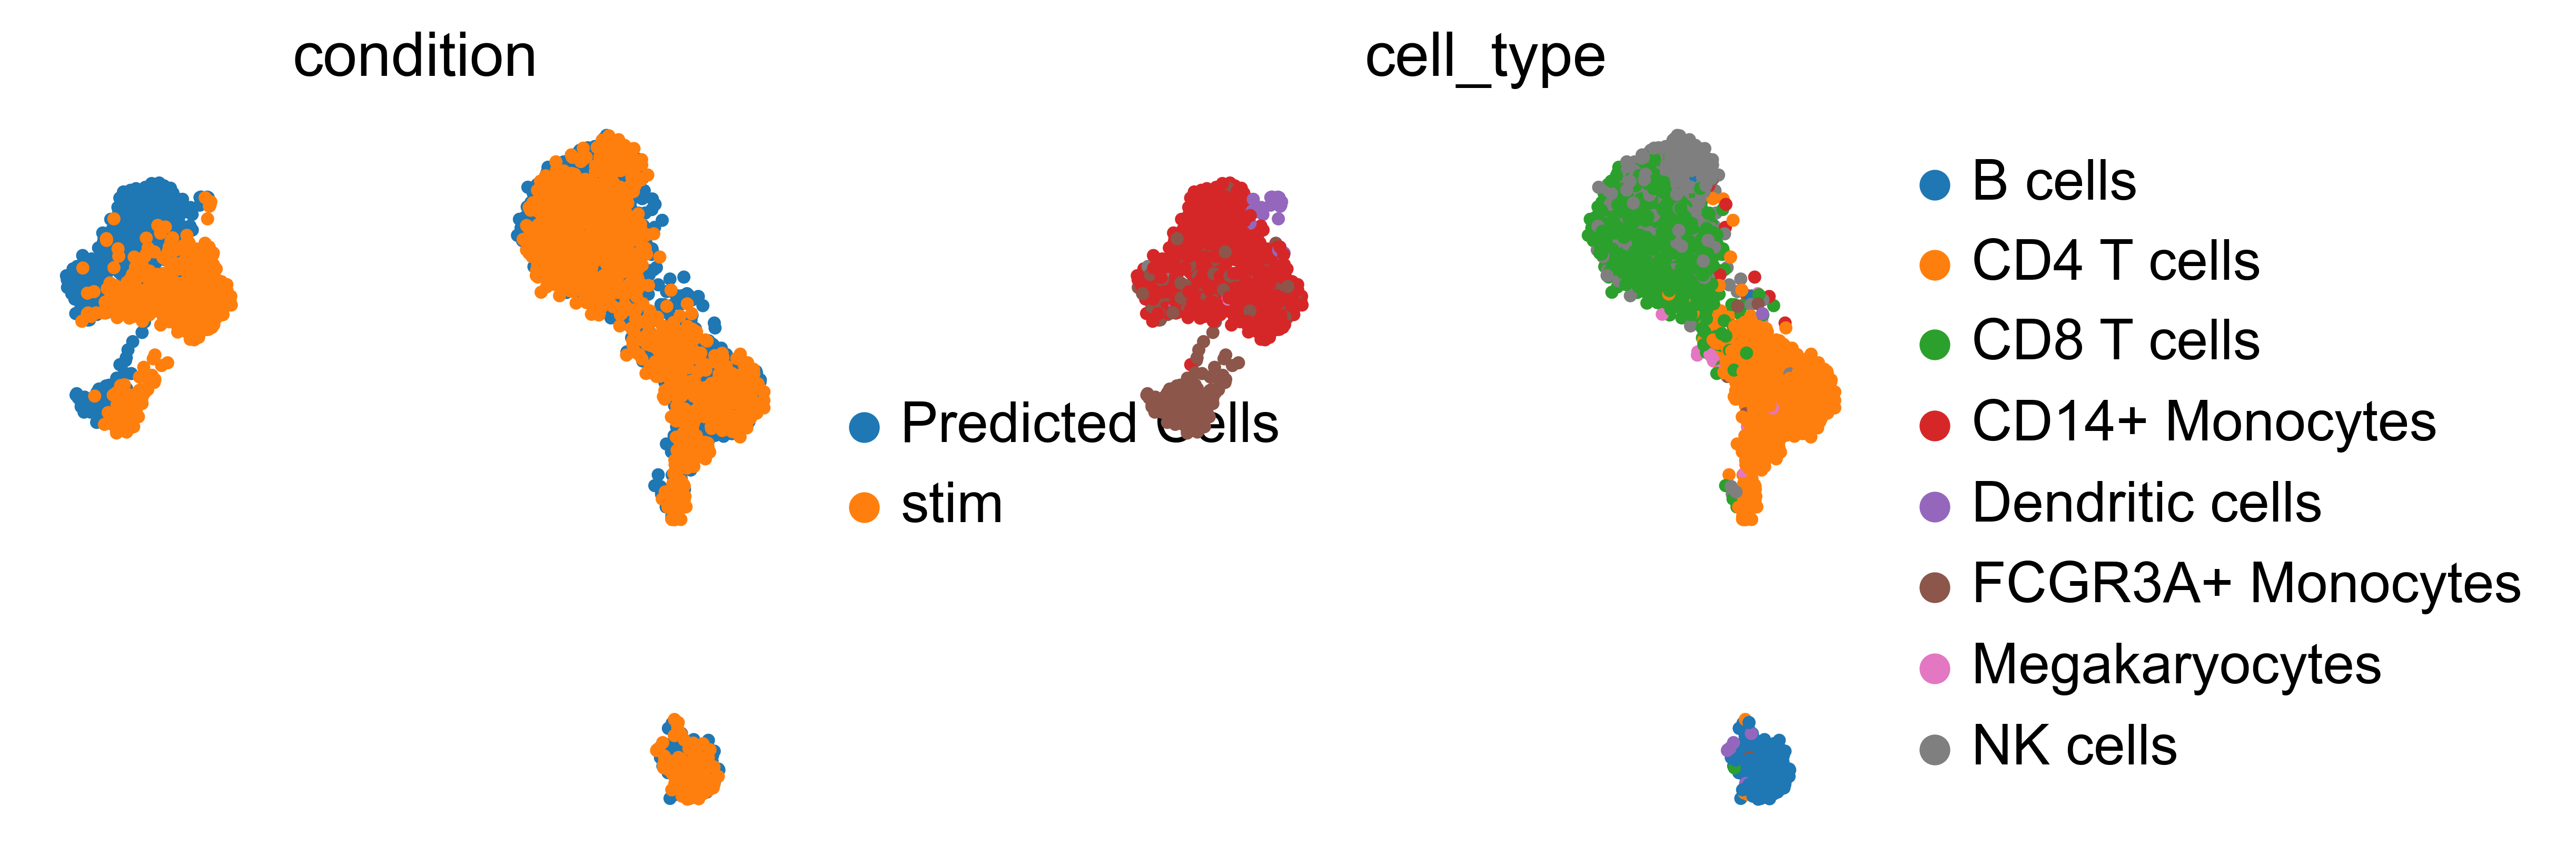

In [84]:
# double check the index as it will be different from GENEX and other method
# index =  3
batch_size = test_data.shape[0]

# creating the metadata for control cells
data = np.array(["ctrl"])
repeated_data = np.tile(data[np.newaxis, :], (batch_size, 1))
pred_meta = pd.DataFrame(repeated_data, columns=["condition"])
pred_meta["cell_type"] = np.array(control_test.obs["cell_type"])

# getting the true population and its metadata
true_perturb_pop = adata_test[adata_test.obs["condition"] == "%s" % (targeted_label)].X.toarray().copy()
pop_meta = adata_test[adata_test.obs["condition"] == "%s" % (targeted_label)].obs

combine_meta = pd.concat([pred_meta[["condition", "cell_type"]], pop_meta[["condition", "cell_type"]]])
combine_gene_exp = np.concatenate([output_results, true_perturb_pop])

print(combine_meta.head())
print(combine_gene_exp.shape)

pred_adata = AnnData(
    X=combine_gene_exp,
    obs=combine_meta
)

# for reproducibility
setup_seed(8)

pca = PCA(n_components = 50, random_state = 8)
pca.fit(adata.X)

X_pca = pred_adata.X @ pca.components_.T
pred_adata.obsm["X_pca"] = X_pca.copy()

# Sort by cell_type
# sorted_adata = pred_adata.obs.sort_values(by='condition')

# Apply the sorting to the AnnData object
# pred_adata = pred_adata[sorted_adata.index]

# compute neighbor and plotting function

sc.pp.neighbors(pred_adata, use_rep='X_pca', n_neighbors=30)
# sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
sc.tl.umap(pred_adata)

custom_palette = cc.glasbey_category10

pred_adata.obs.condition.replace("ctrl", "Predicted Cells", inplace = True)

sc.pl.umap(pred_adata, color=["condition", "cell_type"],
           palette=custom_palette)

In [85]:
output_results @ pca.components_.T

array([[ 28.03928416,   0.23276879,   2.74468208, ...,  -0.96467337,
         -0.61613397,   0.5458928 ],
       [ 24.84702178,  -3.45794123,  -1.07610059, ...,  -0.55219414,
         -0.20902336,  -0.09945042],
       [  6.08214703,  -3.33828568,   0.47082675, ...,  -0.40718572,
         -0.38404534,   0.30077307],
       ...,
       [  8.77390376,  -7.68588839,  -3.59171137, ...,  -0.91778673,
          0.14889203,   0.19218157],
       [ 10.82880973, -13.86027565,  -3.97135698, ...,  -0.49849331,
          0.89035944,   0.21201996],
       [  4.93627312,  -7.14922932,   0.78586614, ...,   0.29383994,
         -0.20888158,   0.79176426]])

In [86]:
np.__version__

'1.24.3'

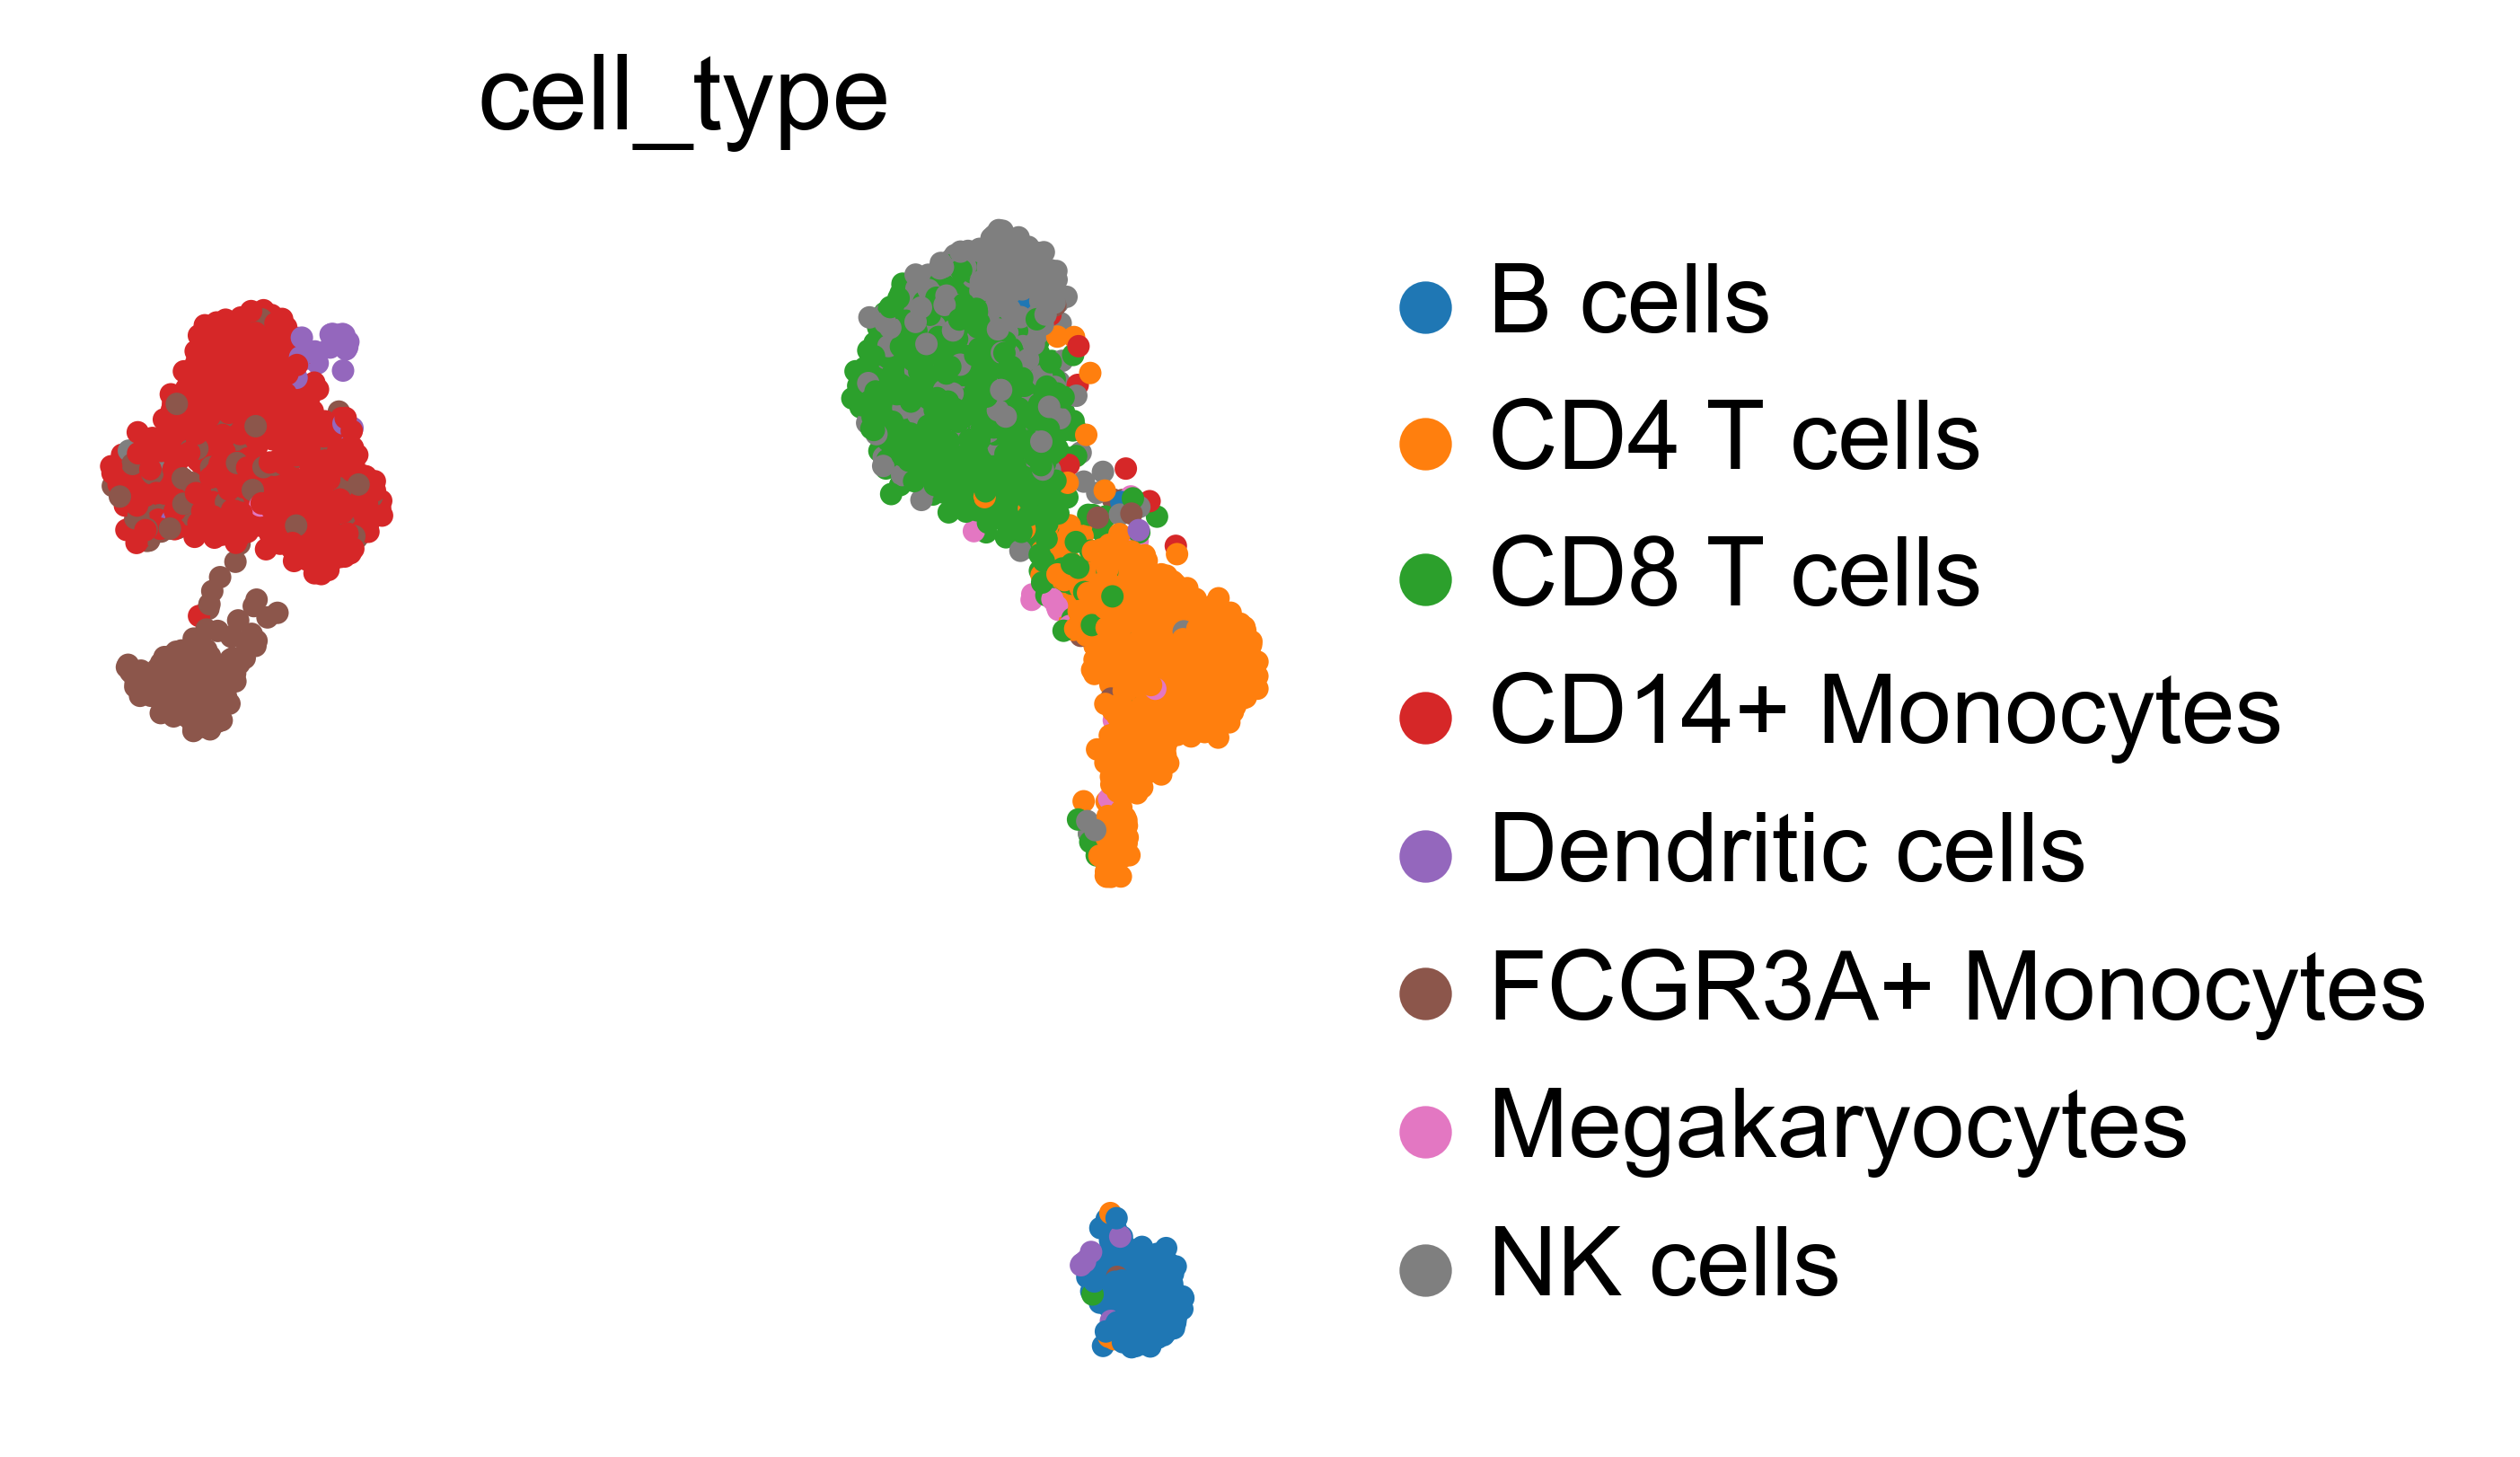

In [87]:
sc.pl.umap(pred_adata, color=["cell_type"],
           palette=custom_palette)

In [88]:
adata_test.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 5.63136985, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.81828073, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.4044575 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [89]:
output_results

array([[ 4.9746266e-01,  4.1122484e+00,  6.3789286e-02, ...,
         4.5798798e-03,  1.1152007e-02, -1.2314709e-02],
       [ 5.6534910e-01,  5.4871335e+00,  3.0686330e-02, ...,
         3.1649843e-03, -2.9377900e-03, -2.4773069e-03],
       [ 1.4100771e-01,  3.2468967e+00,  1.4176379e-01, ...,
        -2.6340932e-03,  1.6410928e-02,  7.1241193e-02],
       ...,
       [ 1.8185738e-01,  4.4817324e+00,  2.0829007e-01, ...,
         4.2896960e-03,  1.9004062e-02,  5.0404601e-02],
       [ 3.1824166e-01,  6.0411043e+00,  3.5320508e-01, ...,
        -5.2877916e-03, -4.2972993e-03,  4.8035778e-02],
       [ 1.8462745e-02,  4.3528519e+00,  1.1198133e-02, ...,
        -4.8844302e-03,  1.8687092e-02,  9.2355963e-03]], dtype=float32)

In [90]:
import ot

def sliced_wasserstein(pred, true, p = 200):
    return ot.sliced_wasserstein_distance(pred, true, n_projections = p)

def downsample_matrices(X, Y):
    """
    Downsamples the smaller matrix to match the size of the larger matrix.

    Args:
      X: First matrix (numpy array).
      Y: Second matrix (numpy array).

    Returns:
      X_downsampled: Downsampled version of X (numpy array).
      Y_downsampled: Downsampled version of Y (numpy array).
    """

    if X.shape[0] < Y.shape[0]:
        # Downsample Y
        indices = np.random.choice(Y.shape[0], size=X.shape[0], replace=False)
        Y_downsampled = Y[indices, :]
        X_downsampled = X
    elif X.shape[0] > Y.shape[0]:
        # Downsample X
        indices = np.random.choice(X.shape[0], size=Y.shape[0], replace=False)
        X_downsampled = X[indices, :]
        Y_downsampled = Y
    else:
        # No downsampling needed
        X_downsampled = X
        Y_downsampled = Y

    return X_downsampled, Y_downsampled

def get_mean_corr(A, B):
    feature_mean_corr = np.corrcoef(A.mean(0), B.mean(0))

    # Set the middle diagonal elements to zero
    np.fill_diagonal(feature_mean_corr, 0)

    feature_mean_corr = np.triu(feature_mean_corr)

    return np.nanmean(np.where(feature_mean_corr!=0,feature_mean_corr,np.nan))

In [91]:
combine_gene_exp

array([[ 4.97462660e-01,  4.11224842e+00,  6.37892857e-02, ...,
         4.57987981e-03,  1.11520067e-02, -1.23147089e-02],
       [ 5.65349102e-01,  5.48713350e+00,  3.06863301e-02, ...,
         3.16498429e-03, -2.93779001e-03, -2.47730687e-03],
       [ 1.41007707e-01,  3.24689674e+00,  1.41763791e-01, ...,
        -2.63409317e-03,  1.64109282e-02,  7.12411925e-02],
       ...,
       [ 0.00000000e+00,  5.63136985e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.81828073e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  3.40445750e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [92]:
pred_adata[pred_adata.obs.condition == "Predicted Cells"].X

ArrayView([[ 4.97462660e-01,  4.11224842e+00,  6.37892857e-02, ...,
             4.57987981e-03,  1.11520067e-02, -1.23147089e-02],
           [ 5.65349102e-01,  5.48713350e+00,  3.06863301e-02, ...,
             3.16498429e-03, -2.93779001e-03, -2.47730687e-03],
           [ 1.41007707e-01,  3.24689674e+00,  1.41763791e-01, ...,
            -2.63409317e-03,  1.64109282e-02,  7.12411925e-02],
           ...,
           [ 1.81857377e-01,  4.48173237e+00,  2.08290070e-01, ...,
             4.28969599e-03,  1.90040618e-02,  5.04046008e-02],
           [ 3.18241656e-01,  6.04110432e+00,  3.53205085e-01, ...,
            -5.28779160e-03, -4.29729931e-03,  4.80357781e-02],
           [ 1.84627455e-02,  4.35285187e+00,  1.11981332e-02, ...,
            -4.88443021e-03,  1.86870918e-02,  9.23559628e-03]])

In [93]:
print(sliced_wasserstein(output_results, true_perturb_pop))
print(get_mean_corr(output_results, true_perturb_pop))

0.2242139411419408
0.9921128123450789


In [94]:
true_perturb_pop

array([[0.        , 5.66678679, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.74317414, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.69275128, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 5.63136985, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.81828073, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.4044575 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [95]:
output_results

array([[ 4.9746266e-01,  4.1122484e+00,  6.3789286e-02, ...,
         4.5798798e-03,  1.1152007e-02, -1.2314709e-02],
       [ 5.6534910e-01,  5.4871335e+00,  3.0686330e-02, ...,
         3.1649843e-03, -2.9377900e-03, -2.4773069e-03],
       [ 1.4100771e-01,  3.2468967e+00,  1.4176379e-01, ...,
        -2.6340932e-03,  1.6410928e-02,  7.1241193e-02],
       ...,
       [ 1.8185738e-01,  4.4817324e+00,  2.0829007e-01, ...,
         4.2896960e-03,  1.9004062e-02,  5.0404601e-02],
       [ 3.1824166e-01,  6.0411043e+00,  3.5320508e-01, ...,
        -5.2877916e-03, -4.2972993e-03,  4.8035778e-02],
       [ 1.8462745e-02,  4.3528519e+00,  1.1198133e-02, ...,
        -4.8844302e-03,  1.8687092e-02,  9.2355963e-03]], dtype=float32)

In [96]:
true_perturb_pop

array([[0.        , 5.66678679, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.74317414, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.69275128, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 5.63136985, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.81828073, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.4044575 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [97]:
metric_data = {}

metric_data["scGen"] = {"sliced_wasserstein": sliced_wasserstein(output_results, true_perturb_pop), "corr mean": get_mean_corr(output_results, true_perturb_pop)}

# Checking for density function of the gene

In [98]:
def uniform_downsample_array(input_array, target_size):
    """
    Perform uniform downsampling of the input array to a target size.

    Parameters:
    - input_array: numpy array to be downsampled.
    - target_size: size of the downsampled array.

    Returns:
    - downsampled_array: numpy array after uniform downsampling.
    """
    # Check if target size is greater than the length of the input array
    if target_size >= len(input_array):
        return input_array

    # Randomly choose indices without replacement
    chosen_indices = np.random.choice(np.arange(len(input_array)), size=target_size, replace=False)

    # Create the downsampled array
    downsampled_array = input_array[chosen_indices]

    return downsampled_array


In [99]:
def plot_gene(gene_name):

    # first get list of the genes index
    all_genes = adata.var.index.values

    # supply gene name to find the index for predicted and observed gene expression
#     gene_name = "PSMB8"
    gene_index = np.where(all_genes == gene_name)[0][0]

    gene_pred = output_results[:, gene_index]
    gene_obs = true_perturb_pop[:, gene_index]
    gene_control = test_data[:, gene_index]

    # downsample so that the obs and the gene pred vector is the same
    if gene_obs.shape[0] > gene_pred.shape[0]:
        gene_obs = uniform_downsample_array(gene_obs, gene_pred.shape[0])
    elif gene_obs.shape[0] < gene_pred.shape[0]:
        gene_pred = uniform_downsample_array(gene_pred, gene_obs.shape[0])
        gene_control = uniform_downsample_array(gene_control, gene_obs.shape[0])

    # Sample data (replace with your actual data)
    data = pd.DataFrame({'Observed': gene_obs, 'scGen': gene_pred, "Control": gene_control})

    # Create the line plot
    # setting the theme
    sns.set_palette("colorblind")
    
    # adding plotting data
    sns.kdeplot(data['Observed'], label='Observed')
    sns.kdeplot(data['scGen'], label='scGen')
    sns.kdeplot(data["Control"], label = "Control")
    
    # adding legend
    plt.legend(loc = "center left", bbox_to_anchor=(1, 0.5))
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(False)

    sns.despine()

    plt.show()

In [100]:
# setup_seed(8)
# plot_gene(gene_name = "VCAN")

In [101]:
# setup_seed(8)
# plot_gene(gene_name = "GPR160")

In [102]:
# setup_seed(8)
# plot_gene(gene_name = "MS4A6A")

In [103]:
# setup_seed(8)
# plot_gene(gene_name = "SERPINB2")

## Before mapping

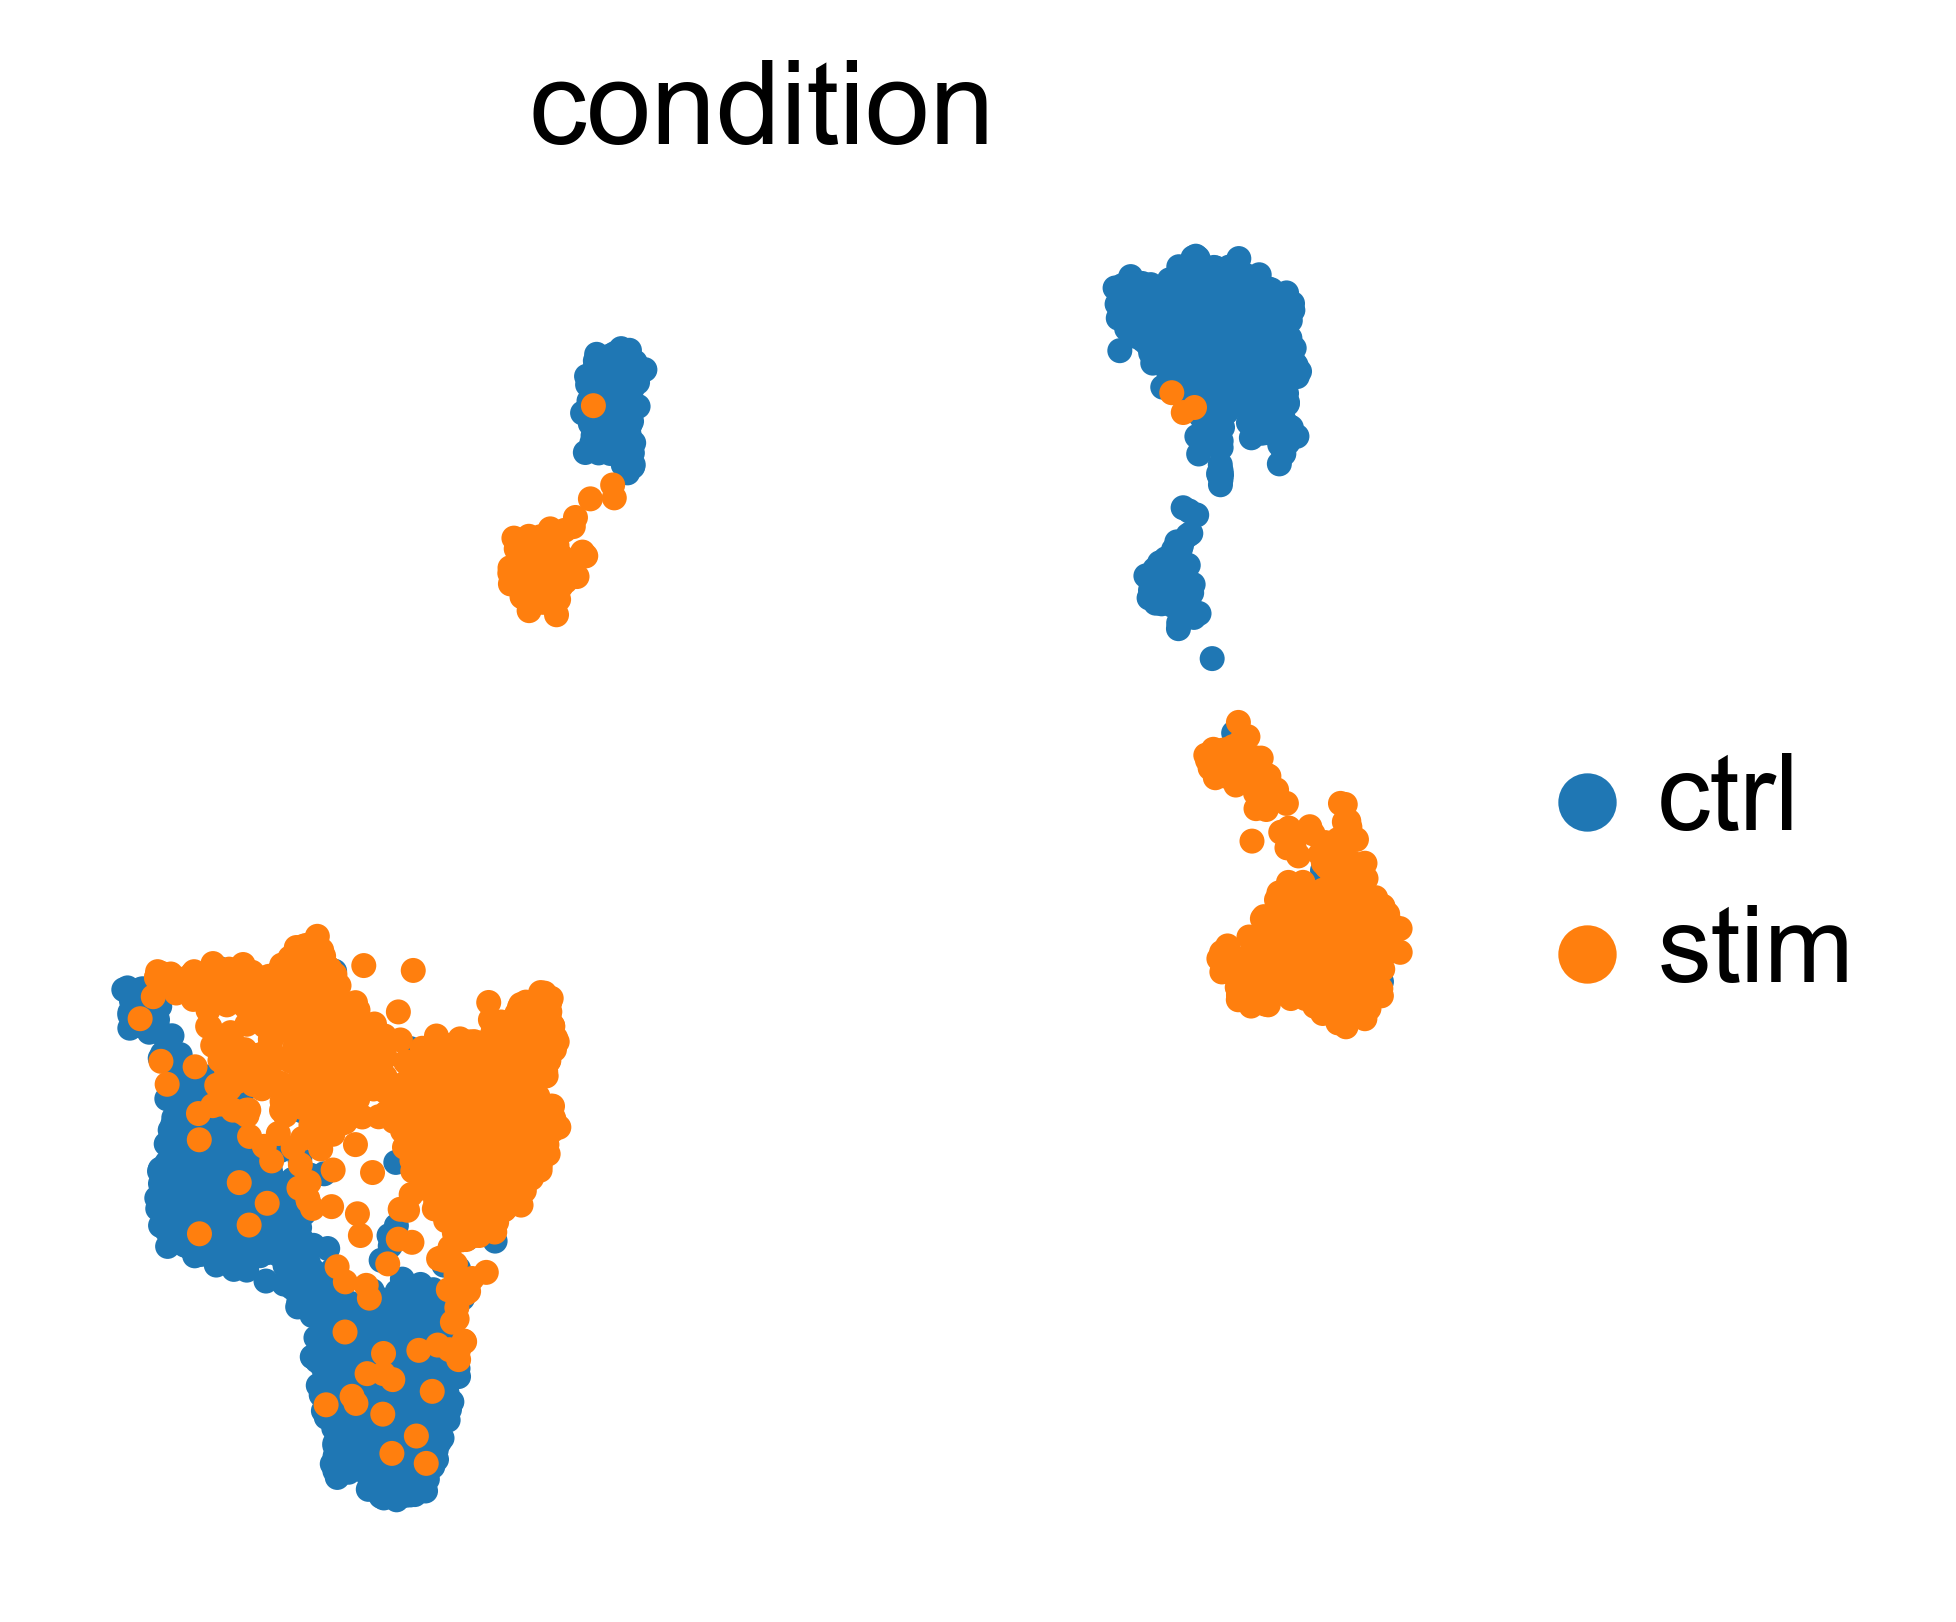

In [104]:
# get the categorical of the condition in aligning with the index and batch number properly
groups = adata.obs['condition'].cat.categories.tolist()

bef_adata = control_test.concatenate(adata_test[adata_test.obs.condition == targeted_label])
# bef_adata = bef_adata.concatenate(adata[adata.obs.condition.isin([groups[gene_1_index]])])

subadata = bef_adata
# plot the raw adata in the training sample
setup_seed(8)

pca = PCA(n_components = 50, random_state = 8)
pca.fit(subadata.X)

X_pca = pca.transform(subadata.X)
subadata.obsm["X_pca"] = X_pca.copy()

sc.pp.neighbors(subadata, use_rep='X_pca', n_neighbors=30)
# sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
sc.tl.umap(subadata)

custom_palette = cc.glasbey_category10

sc.pl.umap(subadata, color=["condition"],
           palette=custom_palette)

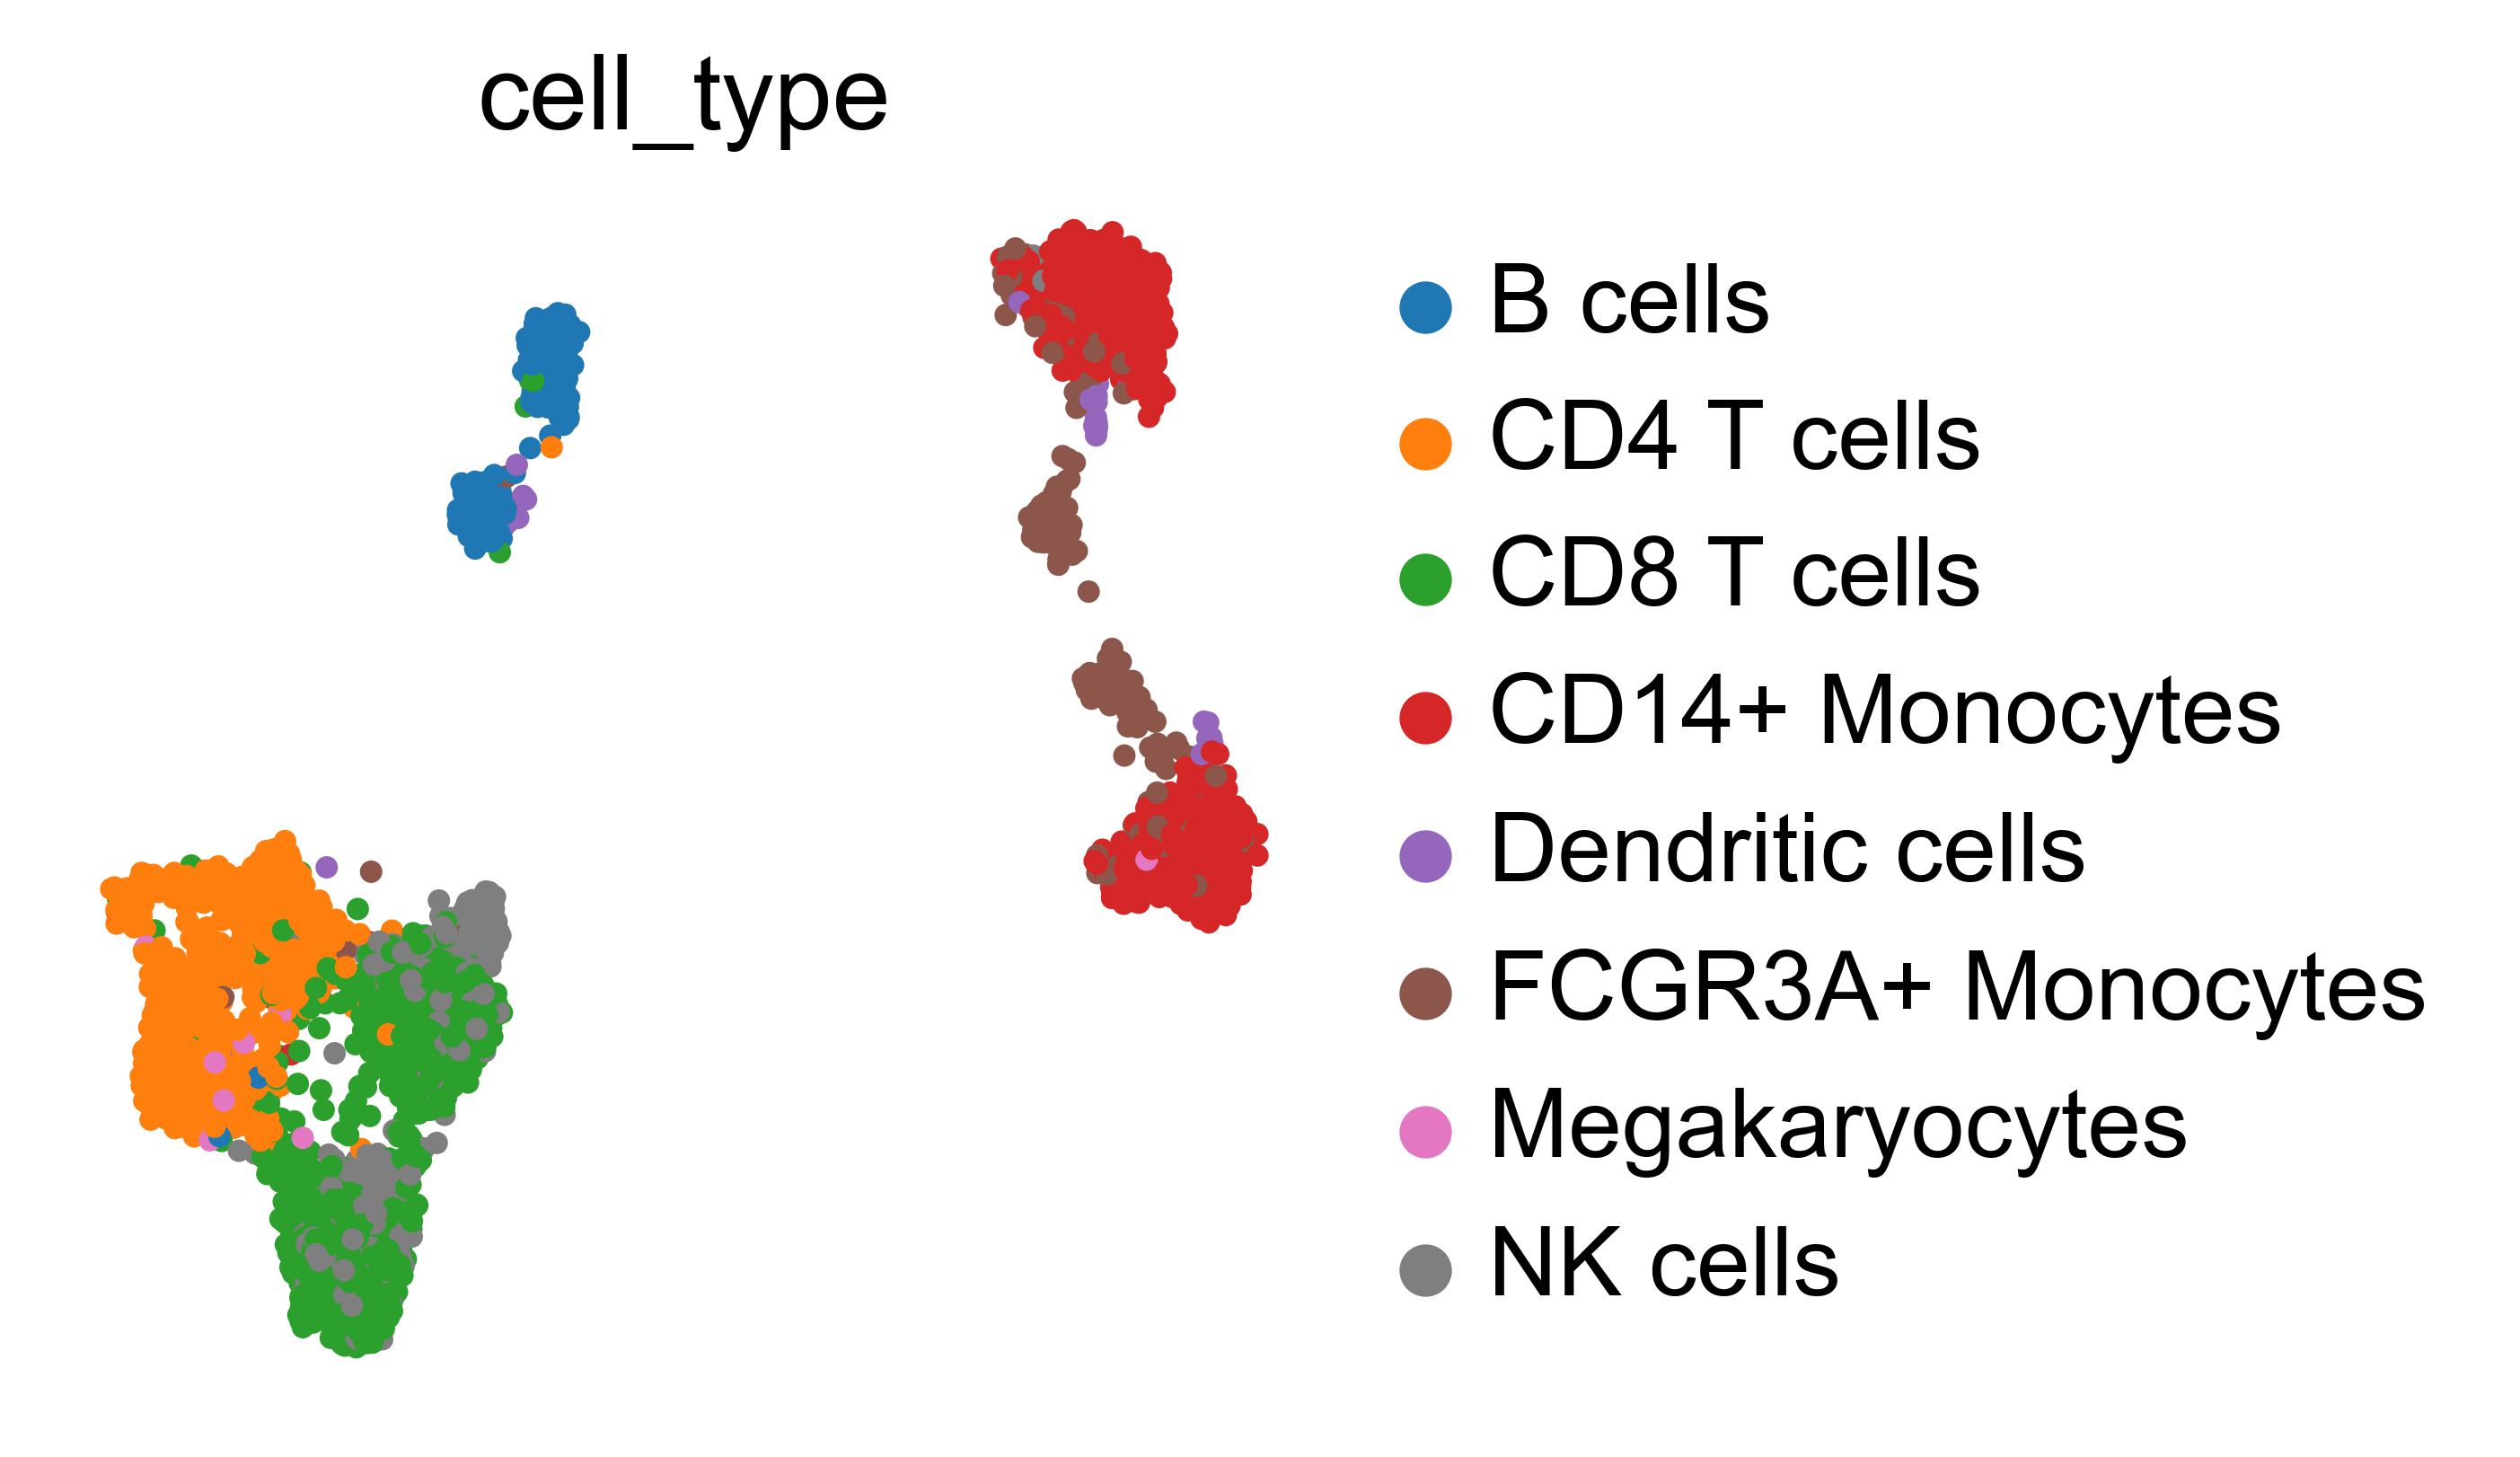

In [105]:
sc.pl.umap(subadata, color=["cell_type"],
           palette=custom_palette)

In [106]:
# for the Identity
control_expr = subadata[subadata.obs["condition"] == "ctrl"].copy().X
perturbed_expr = subadata[subadata.obs["condition"] == targeted_label].copy().X

print(sliced_wasserstein(control_expr, perturbed_expr))
print(get_mean_corr(control_expr, perturbed_expr))

0.2145610528545587
0.8023579215464076


In [107]:
metric_data["Identity"] = {"sliced_wasserstein": sliced_wasserstein(control_expr, perturbed_expr), "corr mean": get_mean_corr(control_expr, perturbed_expr)}

In [108]:
# for observed data
perturbed_expr = subadata[subadata.obs["condition"] == targeted_label].copy().X

print(sliced_wasserstein(perturbed_expr, perturbed_expr))
print(get_mean_corr(perturbed_expr, perturbed_expr))

0.0
0.9999999999999999


In [109]:
metric_data["Observed"] = {"sliced_wasserstein": sliced_wasserstein(perturbed_expr, perturbed_expr), "corr mean": get_mean_corr(perturbed_expr, perturbed_expr)}

In [110]:
# we can add data from other model later on when we can run the CellOT or GEAR or CPA
metric_data

{'scGen': {'sliced_wasserstein': 0.22321230020007005,
  'corr mean': 0.9921128123450789},
 'Identity': {'sliced_wasserstein': 0.22129540406796858,
  'corr mean': 0.8023579215464076},
 'Observed': {'sliced_wasserstein': 0.0, 'corr mean': 0.9999999999999999}}

In [111]:
data

array(['ctrl'], dtype='<U4')

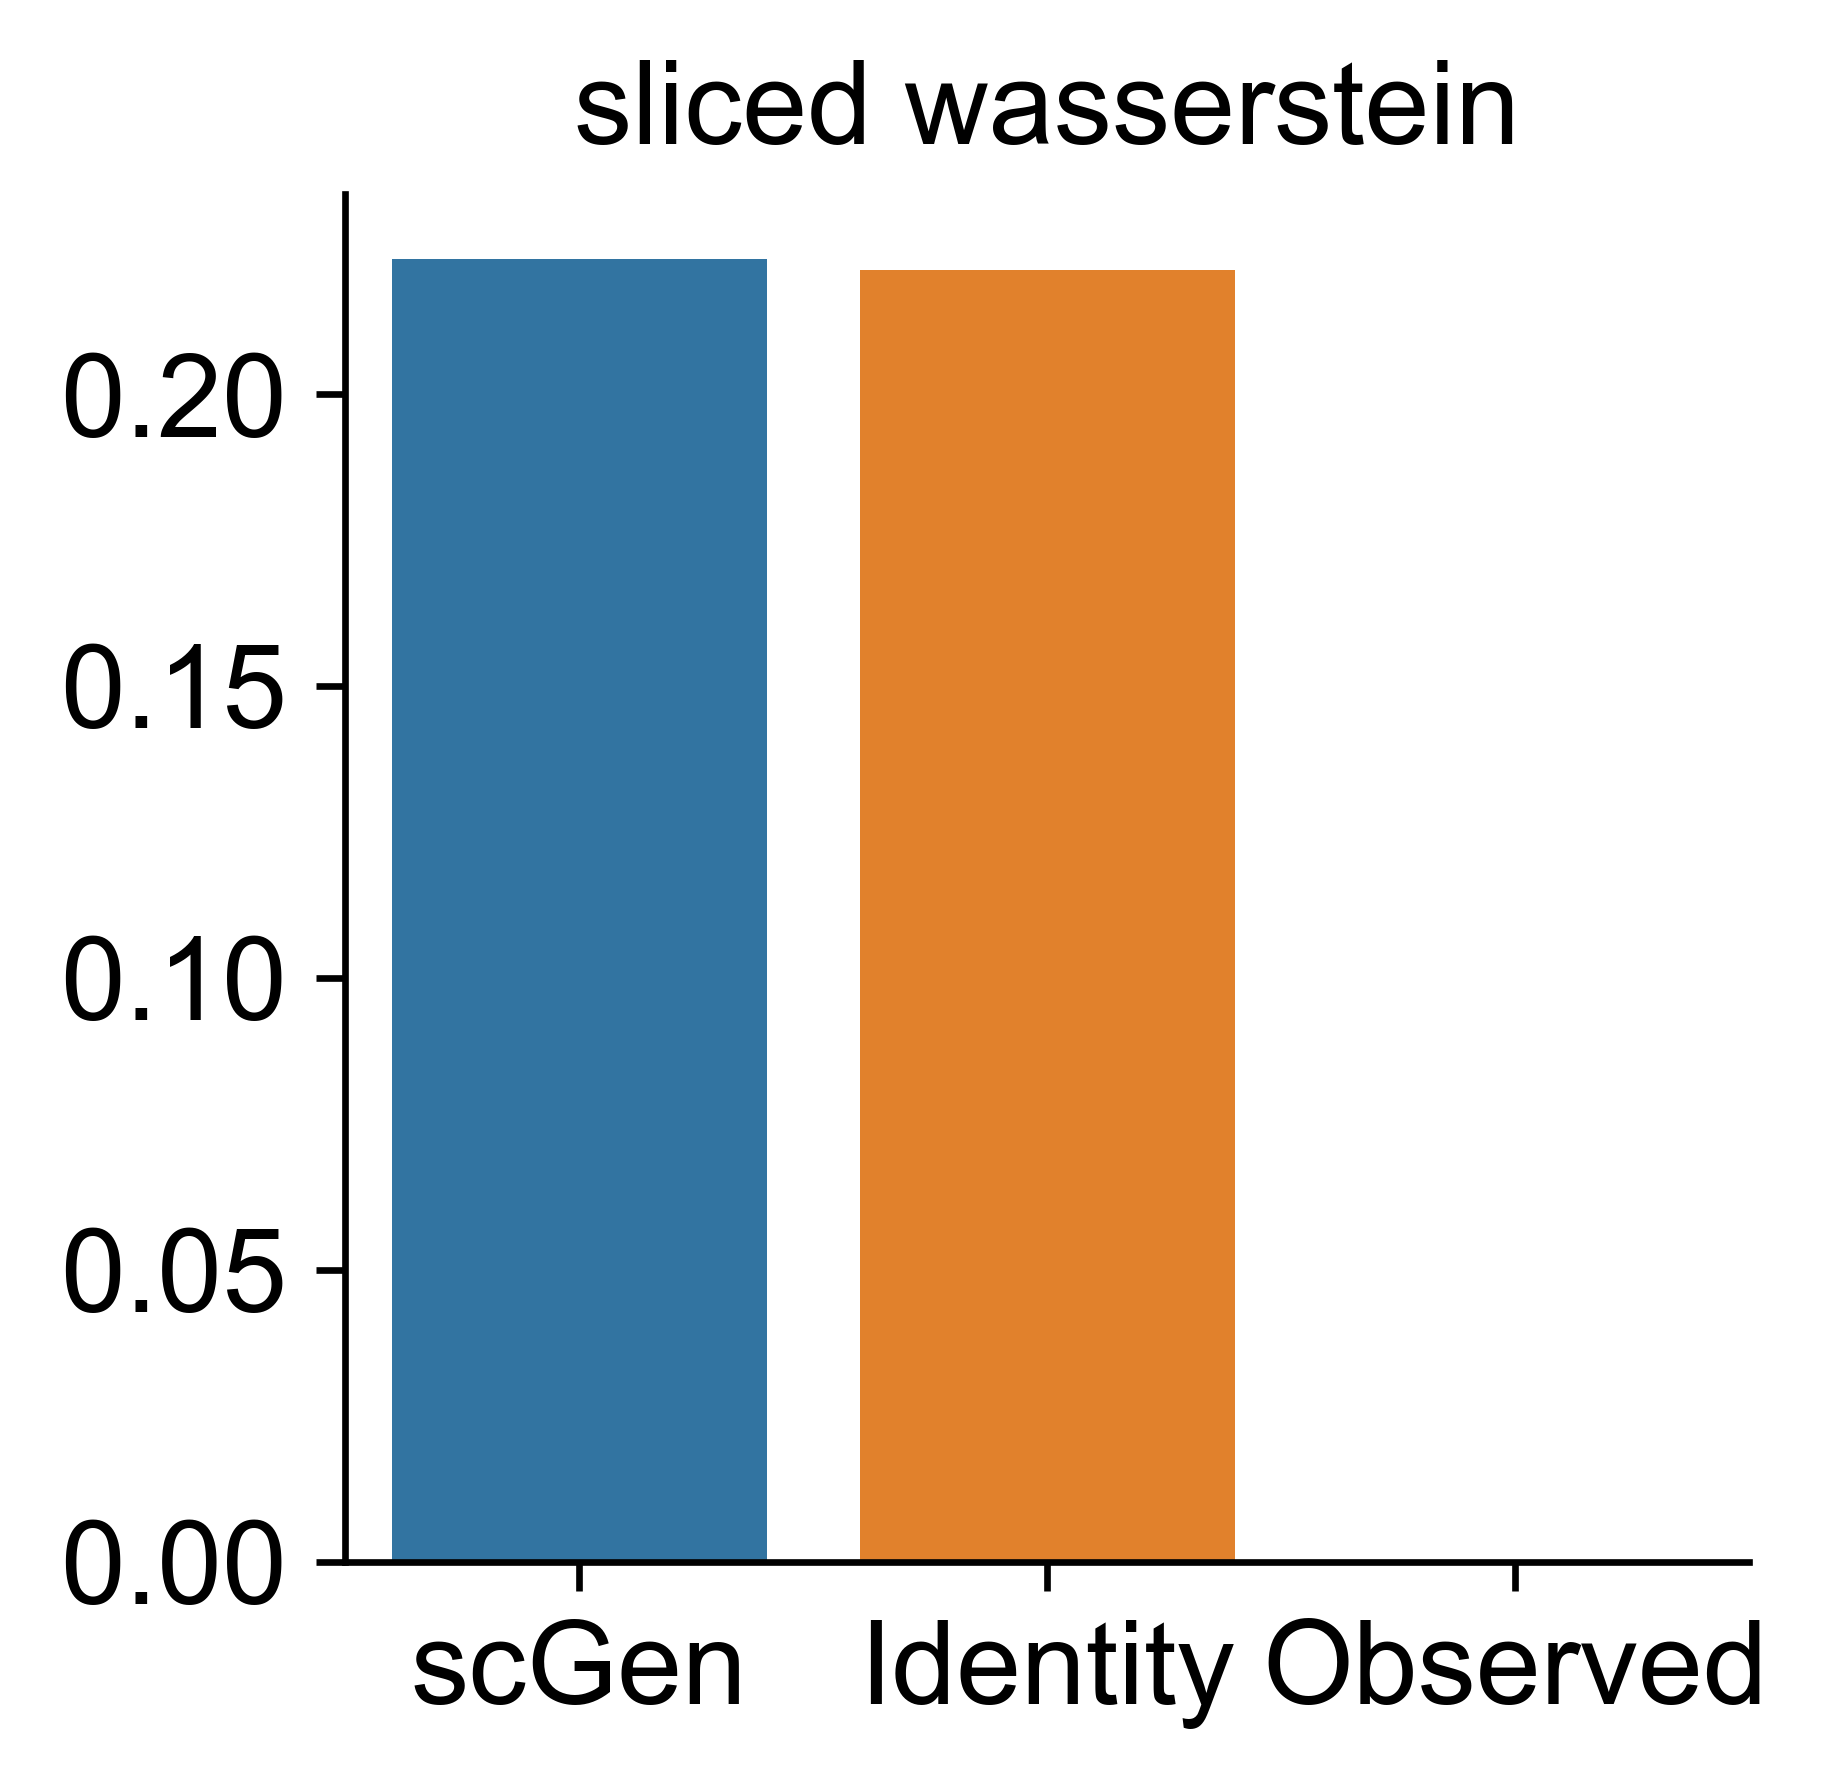

In [112]:
metric_data_df = pd.DataFrame(metric_data).transpose()

data = metric_data_df[["sliced_wasserstein"]]
sns.barplot(x = data.index, y = "sliced_wasserstein", data = data)

plt.grid(False)
# plt.xlabel('')
plt.ylabel('')
plt.title("sliced wasserstein")
sns.despine()

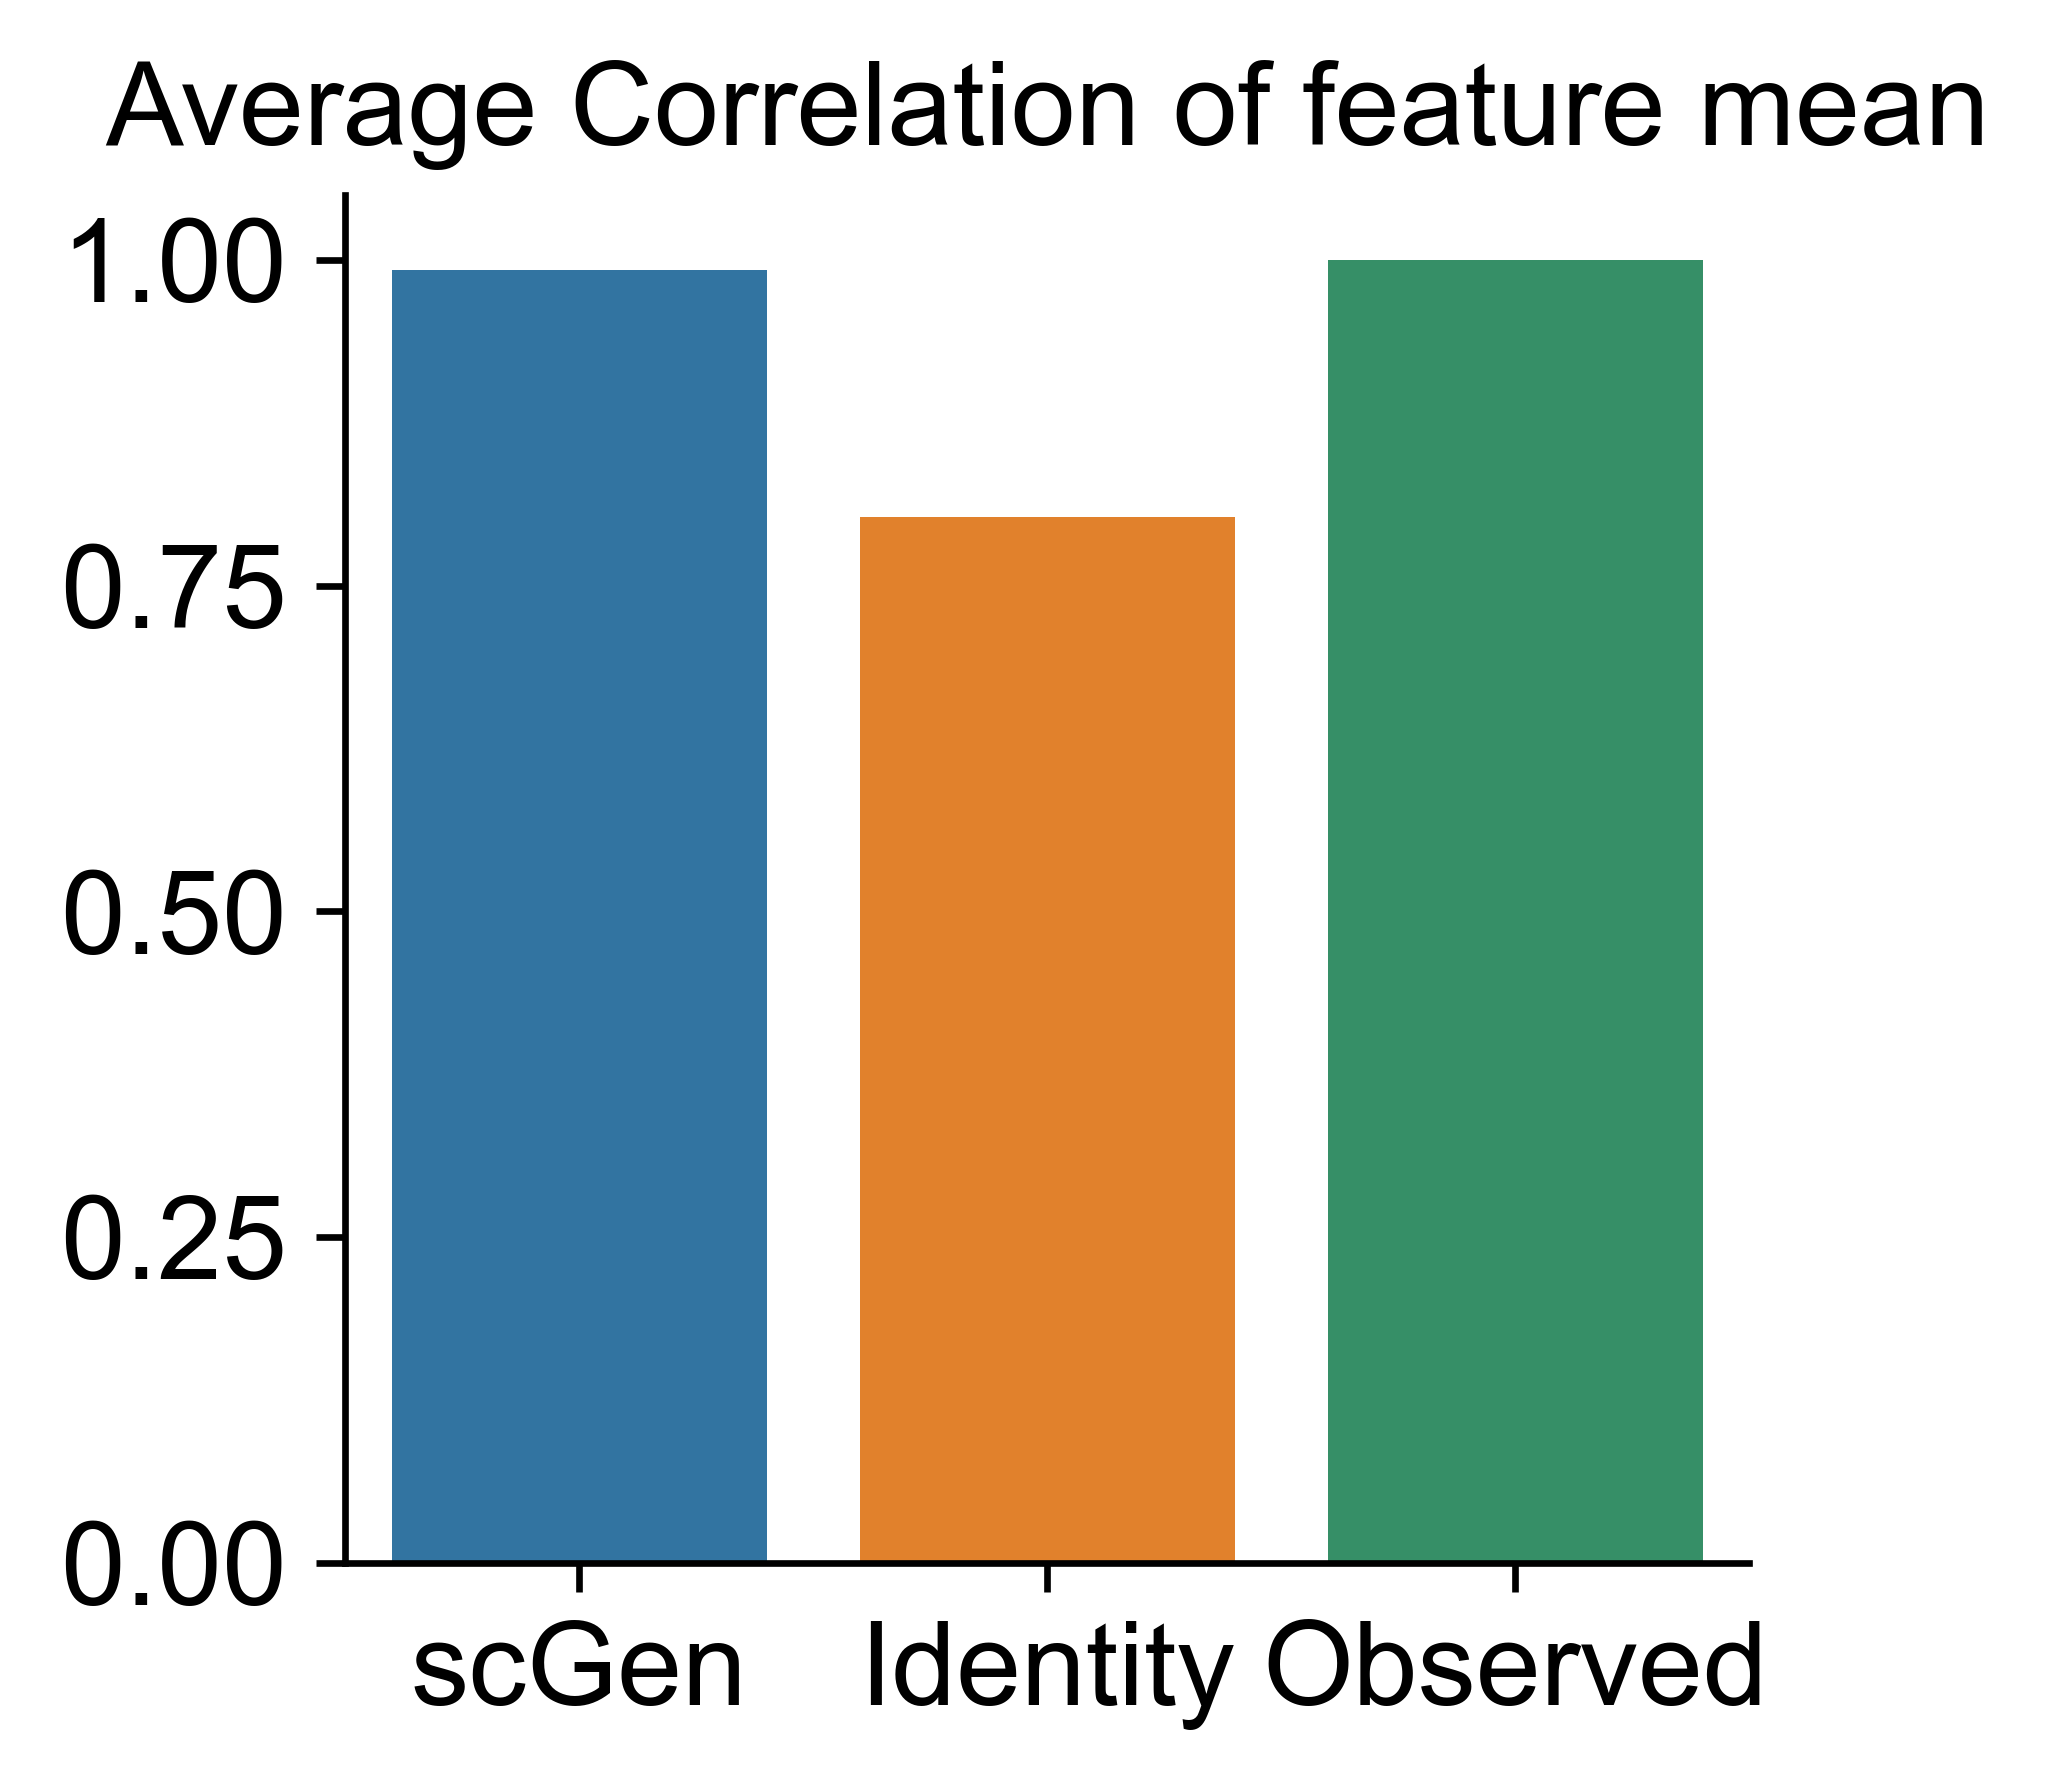

In [113]:
metric_data_df = pd.DataFrame(metric_data).transpose()

data = metric_data_df[["corr mean"]]
sns.barplot(x = data.index, y = "corr mean", data = data)

plt.grid(False)
# plt.xlabel('')
plt.ylabel('')
plt.title("Average Correlation of feature mean")
sns.despine()

In [114]:
# pd.DataFrame(output_results).to_csv("scGen_2i.csv", index = False)
pd.DataFrame(output_results).to_csv("scGen_OOS.csv", index = False)

In [115]:
output_results

array([[ 4.9746266e-01,  4.1122484e+00,  6.3789286e-02, ...,
         4.5798798e-03,  1.1152007e-02, -1.2314709e-02],
       [ 5.6534910e-01,  5.4871335e+00,  3.0686330e-02, ...,
         3.1649843e-03, -2.9377900e-03, -2.4773069e-03],
       [ 1.4100771e-01,  3.2468967e+00,  1.4176379e-01, ...,
        -2.6340932e-03,  1.6410928e-02,  7.1241193e-02],
       ...,
       [ 1.8185738e-01,  4.4817324e+00,  2.0829007e-01, ...,
         4.2896960e-03,  1.9004062e-02,  5.0404601e-02],
       [ 3.1824166e-01,  6.0411043e+00,  3.5320508e-01, ...,
        -5.2877916e-03, -4.2972993e-03,  4.8035778e-02],
       [ 1.8462745e-02,  4.3528519e+00,  1.1198133e-02, ...,
        -4.8844302e-03,  1.8687092e-02,  9.2355963e-03]], dtype=float32)

In [116]:
adata_test[adata_test.obs.condition == targeted_label].X.toarray()

array([[0.        , 5.66678679, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.74317414, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.69275128, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 5.63136985, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.81828073, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.4044575 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [117]:
output_results

array([[ 4.9746266e-01,  4.1122484e+00,  6.3789286e-02, ...,
         4.5798798e-03,  1.1152007e-02, -1.2314709e-02],
       [ 5.6534910e-01,  5.4871335e+00,  3.0686330e-02, ...,
         3.1649843e-03, -2.9377900e-03, -2.4773069e-03],
       [ 1.4100771e-01,  3.2468967e+00,  1.4176379e-01, ...,
        -2.6340932e-03,  1.6410928e-02,  7.1241193e-02],
       ...,
       [ 1.8185738e-01,  4.4817324e+00,  2.0829007e-01, ...,
         4.2896960e-03,  1.9004062e-02,  5.0404601e-02],
       [ 3.1824166e-01,  6.0411043e+00,  3.5320508e-01, ...,
        -5.2877916e-03, -4.2972993e-03,  4.8035778e-02],
       [ 1.8462745e-02,  4.3528519e+00,  1.1198133e-02, ...,
        -4.8844302e-03,  1.8687092e-02,  9.2355963e-03]], dtype=float32)

In [118]:
# clear GPU
import torch
torch.cuda.empty_cache()

In [119]:
output_results

array([[ 4.9746266e-01,  4.1122484e+00,  6.3789286e-02, ...,
         4.5798798e-03,  1.1152007e-02, -1.2314709e-02],
       [ 5.6534910e-01,  5.4871335e+00,  3.0686330e-02, ...,
         3.1649843e-03, -2.9377900e-03, -2.4773069e-03],
       [ 1.4100771e-01,  3.2468967e+00,  1.4176379e-01, ...,
        -2.6340932e-03,  1.6410928e-02,  7.1241193e-02],
       ...,
       [ 1.8185738e-01,  4.4817324e+00,  2.0829007e-01, ...,
         4.2896960e-03,  1.9004062e-02,  5.0404601e-02],
       [ 3.1824166e-01,  6.0411043e+00,  3.5320508e-01, ...,
        -5.2877916e-03, -4.2972993e-03,  4.8035778e-02],
       [ 1.8462745e-02,  4.3528519e+00,  1.1198133e-02, ...,
        -4.8844302e-03,  1.8687092e-02,  9.2355963e-03]], dtype=float32)

In [120]:
adata_test.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 5.63136985, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.81828073, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.4044575 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [121]:
pop_meta

,sample_id,condition,cluster,cell_type,multiplets,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_counts
barcode,,,,,,,,,,,
AAACATACTCAGGT-1,1016,stim,8,CD14+ Monocytes,singlet,563,563,2152.0,0.0,0.0,2152.0
AAACATTGAAGGGC-1,1016,stim,10,CD8 T cells,singlet,357,357,703.0,0.0,0.0,703.0
AAACATTGGTACCA-1,1016,stim,4,Megakaryocytes,singlet,522,522,1202.0,0.0,0.0,1202.0
AAACATTGTGCTAG-1,1016,stim,3,CD4 T cells,singlet,646,646,1111.0,0.0,0.0,1111.0
AAAGACGACCCTTG-1,1016,stim,10,NK cells,singlet,409,409,913.0,0.0,0.0,913.0
...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACCCATGA-1,1016,stim,10,CD8 T cells,singlet,478,478,1084.0,0.0,0.0,1084.0
TTTGACTGACGTAC-1,1016,stim,6,CD4 T cells,singlet,564,564,1423.0,0.0,0.0,1423.0
TTTGCATGAGGTTC-1,1016,stim,8,CD14+ Monocytes,singlet,418,418,1043.0,0.0,0.0,1043.0
